In [3]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from datetime import datetime

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [4]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats_apermag/'

In [17]:
def add_photo_flag(cat_name, c20_zname='lp_zPDF', c20_massname='lp_mass_med'):
    cat_matched = Table.read(cat_name)
    cat_matched = cat_matched[cat_matched[c20_zname]>0]
    cat_matched = cat_matched[cat_matched[c20_massname]>0]
    
    max_phot_err = 0.2
    cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < max_phot_err) )| \
             ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < max_phot_err) )
    cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < max_phot_err) ) 
    cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < max_phot_err) )
    cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < max_phot_err) )
    cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < max_phot_err) )
    cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < max_phot_err) )
    flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)
    
    cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < max_phot_err) )
    cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < max_phot_err) )
    cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < max_phot_err) )
    cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < max_phot_err) )
    
    flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)
    cond_ch1 = ( (cat_matched['MAG_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH1_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] < 0.5) )
    cond_ch2 = ( (cat_matched['MAG_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH2_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] < 0.5) )
    flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 
    
    flag_list = [flag_optical,flag_nir,flag_irac,flag_nir]
    flag_name_list = ['flag_optical','flag_nir','flag_irac','flag_nir']
        
    if len(cat_matched) != len(flag_optical) or len(cat_matched) != len(flag_nir) or len(cat_matched) != len(flag_irac):
        print('lengths do not match')
    else:
        col_flag_optical = Column(name='flag_optical', data=flag_optical)
        col_flag_nir = Column(name='flag_nir', data=flag_nir)
        col_flag_irac = Column(name='flag_irac', data=flag_irac)
        if 'flag_optical' in cat_matched.keys():
            cat_matched.remove_column('flag_optical')
        if 'flag_nir' in cat_matched.keys():
            cat_matched.remove_column('flag_nir')
        if 'flag_irac' in cat_matched.keys():
            cat_matched.remove_column('flag_irac')
            
        cat_matched.add_columns([col_flag_optical, col_flag_nir, col_flag_irac])
        cat_matched.write(cat_name, overwrite=True)

#### trim down output catalogs
keep the full catalogs on Graham

In [5]:
prefix = 'pcat_' # '','v9pcat'

cat_names = ['COSMOS_deep','DEEP_deep','ELAIS_deep','XMM-LSS_deep']
# cat_names = ['XMM-LSS_deep']
for cat_name in cat_names:
    print(graham_output_dir+prefix+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits')
    if cat_name != 'XMM-LSS_deep':
        output_cat = Table.read(graham_output_dir+prefix+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits')
    else:
        output_cat = Table.read(graham_output_dir+prefix+cat_name+'_cat_out_nomaglimit_noirac_il_nz_prior_formass.fits')
    
    
    keys_set1 = [key for key in output_cat.keys() if 'NBAND_USED' in key]
    keys_set2 = [key for key in output_cat.keys() if 'CONTEXT' in key]
    # keys_set3 = [key for key in output_cat.keys() if 'APER' in key]
    keys_other = ['IDENT','EBV_BEST', 'STRING_INPUT','isOutsideMask','isStar']
    if cat_name == 'COSMOS_deep':
        keys_other.append('HSC_i_MAGERR_AUTO')
    else:
        keys_other.append('FLAG_FIELD')
    keys = keys_set1 + keys_set2 + keys_other
    
    for key in keys:
        try:
            output_cat.remove_column(key)
        except KeyError:
            print(key, 'already removed')
        
    print(len(output_cat.keys()))
    print('')
    
    if cat_name != 'XMM-LSS_deep':
        output_cat.write(graham_output_dir+prefix+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits', overwrite=True)
    else:
        output_cat.write(graham_output_dir+prefix+cat_name+'_cat_out_nomaglimit_noirac_il_nz_prior_formass.fits', overwrite=True)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats_apermag/pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits
isOutsideMask already removed
isStar already removed
HSC_i_MAGERR_AUTO already removed
119

/Users/lejay/research/lephare_dev/my_code/graham_output_cats_apermag/pcat_DEEP_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits
isOutsideMask already removed
isStar already removed
FLAG_FIELD already removed
91

/Users/lejay/research/lephare_dev/my_code/graham_output_cats_apermag/pcat_ELAIS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits
isOutsideMask already removed
isStar already removed
FLAG_FIELD already removed
91

/Users/lejay/research/lephare_dev/my_code/graham_output_cats_apermag/pcat_XMM-LSS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits
isOutsideMask already removed
isStar already removed
FLAG_FIELD already removed
103



#### load in central COSMOS catalog and match with C20

In [15]:
# the output catalogs (from graham)
name_tag = '_08squdeg'
detect_limit = '_nolimit'
nz_prior = '_nz_prior'
sfq_added = '_sfq_added'
graham_output_dir_central_cosmos = dev_path + 'graham_output_cats_apermag/'
cat_output_nonir_name = graham_output_dir_central_cosmos+'pcat_cat_out'+name_tag+'_nonir_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
print(cat_output_nonir_name)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats_apermag/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass_sfq_added.fits


#### load in E-COSMOS catalog and match with C20

In [5]:
cat_output_nonir_name = graham_output_dir+'pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits'
print(cat_output_nonir_name)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats_apermag/pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits


match with C20

In [20]:
cat_output_name = cat_output_nonir_name
cat_c20_name = '/Users/lejay/COSMOS2020/COSMOS2020_CLASSIC_FARMER_combine_v2.2.fits'
combined_cat_name = cat_output_name.replace('_sfq_added.fits','_c20added.fits')

cmd = 'java -jar stilts.jar tmatch2 matcher=sky params=1.0\
   in1='+cat_output_name+' values1="RA DEC" \
   in2='+cat_c20_name+' values2="ALPHA_J2000_farmer DELTA_J2000_farmer" \
   out='+ combined_cat_name
# print(cmd)
os.system(cmd)

cat_original = Table.read(cat_output_name)
cat_matched = Table.read(combined_cat_name)

# arr,ind = np.unique(cat_matched['STRING_INPUT'],return_index=True)
# cat_matched = cat_matched[ind]
cat_matched = cat_matched[cat_matched['MAG_AUTO_CH1_CORR']<99]
cat_matched = cat_matched[cat_matched['MAG_AUTO_CH2_CORR']<99]
cat_matched = cat_matched[cat_matched['lp_zPDF_farmer']>0]
cat_matched = cat_matched[~np.isnan(cat_matched['lp_mass_med_farmer'])]
print(len(cat_matched))

# inside central cosmos (inside j) flag
# cat_matched = cat_matched[cat_matched['inside_j']==False]

max_phot_err = 0.15
cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < max_phot_err) )| \
         ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < max_phot_err) )
cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < max_phot_err) ) 
cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < max_phot_err) )
cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < max_phot_err) )
cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < max_phot_err) )
cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < max_phot_err) )
flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)
cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < max_phot_err) )
cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < max_phot_err) )
cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < max_phot_err) )
cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < max_phot_err) )
flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)
cond_ch1 = ( (cat_matched['MAG_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH1_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] < 0.5) )
cond_ch2 = ( (cat_matched['MAG_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH2_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] < 0.5) )
flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 

flag_list = [flag_optical,flag_nir,flag_irac,flag_nir]
flag_name_list = ['flag_optical','flag_nir','flag_irac','flag_nir']
    
if len(cat_matched) != len(flag_optical) or len(cat_matched) != len(flag_nir) or len(cat_matched) != len(flag_irac):
    print('lengths do not match')
else:
    print(cat_output_name)
    print(len(cat_matched),'/',len(cat_original))
    
    col_flag_optical = Column(name='flag_optical', data=flag_optical)
    col_flag_nir = Column(name='flag_nir', data=flag_nir)
    col_flag_irac = Column(name='flag_irac', data=flag_irac)
    col_log_ezmass = Column(name='log_ez_mass_p500', data=np.log10(cat_matched['ez_mass_p500_farmer']))
    if 'flag_optical' in cat_matched.keys():
        cat_matched.remove_column('flag_optical')
    if 'flag_nir' in cat_matched.keys():
        cat_matched.remove_column('flag_nir')
    if 'flag_irac' in cat_matched.keys():
        cat_matched.remove_column('flag_irac')
    if 'log_ez_mass_p500' in cat_matched.keys():
        cat_matched.remove_column('log_ez_mass_p500')
    
    cat_matched.add_columns([col_flag_optical, col_flag_nir, col_flag_irac,col_log_ezmass])
    cat_matched.write(combined_cat_name, overwrite=True)

291792
/Users/lejay/research/lephare_dev/my_code/graham_output_cats_apermag/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass_sfq_added.fits
291792 / 353107


#### load in E-COSMOS catalog and match with C20

In [10]:
cat_mycosmos_name = '/Volumes/LejaySSD/pcat_lephare_masses/COSMOS_galaxies_240408.fits'
cat_c20_farmer_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_FARMER_R1_v2.2_trim.fits'
cat_c20_classic_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.2_trim.fits'
combined_cat_name = '/Volumes/LejaySSD/pcat_lephare_masses/COSMOS_galaxies_240408_c20added.fits'

col_list_farmer = "'ALPHA_J2000 DELTA_J2000 HSC_i_MAG FLAG_COMBINED lp_type lp_zPDF lp_mass_med'"
col_list_classic = "'ALPHA_J2000 DELTA_J2000 HSC_i_MAG_AUTO HSC_i_MAG_APER2 total_off2 lp_type FLAG_COMBINED lp_zPDF lp_mass_med'"
cmd = 'java -jar stilts.jar tmatchn multimode=pairs nin=3 matcher=sky params=1.0\
   in1='+cat_mycosmos_name+' values1="RA DEC" \
   in2='+cat_c20_farmer_name+' values2="ALPHA_J2000 DELTA_J2000" \
   in3='+cat_c20_classic_name+' values3="ALPHA_J2000 DELTA_J2000" \
   out='+ combined_cat_name+' icmd2="keepcols '+col_list_farmer+'" '+' icmd3="keepcols '+col_list_classic+'" join1=always'
# print(cmd)

os.system(cmd)

cat_matched = Table.read(combined_cat_name)
# remove unnecessary columns
cat_matched = Table.read(combined_cat_name)
cat_matched.remove_columns(['ALPHA_J2000_2','DELTA_J2000_2','ALPHA_J2000_3','DELTA_J2000_3'])
for keyname in cat_matched.keys():
    if '_2' in keyname:
        cat_matched.rename_column(keyname,keyname.replace('_2','_farmer'))
    elif '_3' in keyname:
        cat_matched.rename_column(keyname,keyname.replace('_3','_classic'))

cat_matched.remove_columns(['FLAG_FIELD_BINARY','tract','patch'])     
cat_matched.write(combined_cat_name, overwrite=True)

#### redshift checks with C20

/Users/lejay/research/lephare_dev/my_code/graham_output_cats_apermag/pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass_sfq_added.fits


Text(0.02, 0.84, '$\\eta=$7.6\\% (81971), $\\sigma_{NMAD}=0.077$')

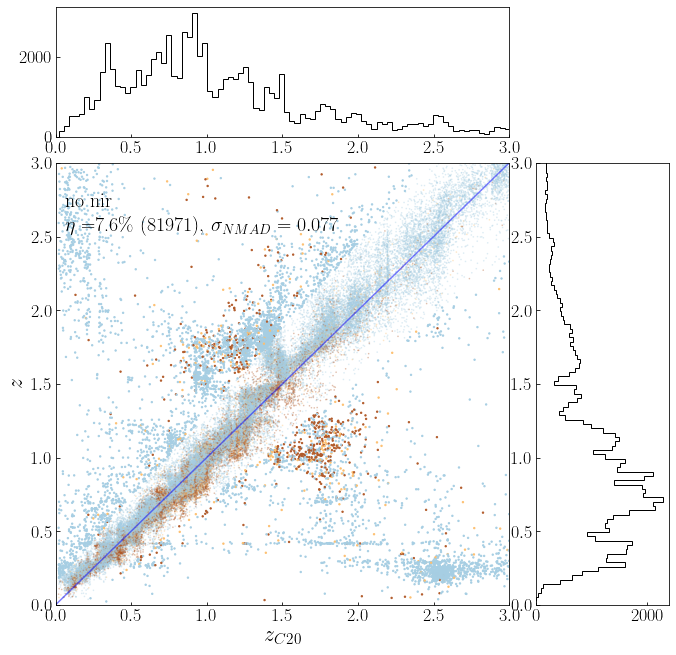

In [49]:
# redshift comparison

sfq = 'all'
z_keyname = 'ZPHOT_G_6B'

cat_name = cat_output_nonir_name
print(cat_name)
cat_output_c20added = Table.read(cat_name.replace('_sfq_added.fits','_c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF_farmer']>0]
cat_output_c20added = cat_output_c20added[cat_output_c20added['i']<25]

flag_photoz = cat_output_c20added['flag_photoz']==1  # internally consistent photoz within C20 catalog
flag_optical = cat_output_c20added['flag_optical'] 
flag_irac = cat_output_c20added['flag_irac'] 
flag_nir = cat_output_c20added['flag_nir'] 

# only show galaxies with good photo
cond_filters = (flag_optical>4) 

# COSMOS consistent photoz objects only
cond = flag_photoz & cond_filters
        
fig = plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(4, 4)
ax_main = plt.subplot(gs[1:4, :3])
ax_xDist = plt.subplot(gs[0, :3],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:4, 3],sharey=ax_main)

ax_main.scatter(cat_output_c20added[cond]['lp_zPDF_farmer'], cat_output_c20added[cond][z_keyname],s=0.5,c=flag_irac[cond],alpha=0.3,cmap='Paired')
ax_main.set_xlim([0,3])
ax_main.set_ylim([0,3])
ax_main.set_xlabel('$z_{C20}$',fontsize=22)
ax_main.set_ylabel('$z$',fontsize=22)

# 1to1 line
ax_main.plot([0,3],[0,3],color='b',alpha=0.5)

bin_number = 200
ax_xDist.hist(cat_output_c20added[cond]['lp_zPDF_farmer'],histtype='step',color='k',bins=bin_number,align='mid')
ax_yDist.hist(cat_output_c20added[cond][z_keyname],histtype='step',color='k',bins=bin_number,orientation='horizontal',align='mid')

# print out outlier fraction & plot outliers with larger points
outlier_factor = 0.15
cat_outliers = cat_output_c20added[cond][abs(cat_output_c20added[cond]['lp_zPDF_farmer']-cat_output_c20added[cond][z_keyname])>outlier_factor*(1+cat_output_c20added[cond]['lp_zPDF_farmer'])]
flag_outliers = flag_irac[cond][abs(cat_output_c20added[cond]['lp_zPDF_farmer']-cat_output_c20added[cond][z_keyname])>outlier_factor*(1+cat_output_c20added[cond]['lp_zPDF_farmer'])]
ax_main.scatter(cat_outliers['lp_zPDF_farmer'], cat_outliers[z_keyname],s=2,c=flag_outliers,alpha=0.9,cmap='Paired')

num_outliers_15 = len(cat_outliers)
deltaz = np.array(cat_output_c20added[cond][z_keyname]-cat_output_c20added[cond]['lp_zPDF_farmer'])
sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
ax_main.annotate('no nir',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
ax_main.annotate('$\eta=$'+str(round(num_outliers_15/len(cat_output_c20added[cond])*100,1))+'\% '+'('+str(len(flag_irac[cond]))+'), $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')

#### test on using z_G

In [23]:
cat_output_name = graham_output_dir+'pcat_small_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits'
cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
combined_cat_name = cat_output_name.replace('.fits','_C20added.fits')

col_list = "'RA DEC MASS_MED ZPHOT sfq_nuvrk'"
cmd = 'java -jar stilts.jar tmatch2 matcher=sky params=1.0\
   in1='+cat_output_name+' values1="RA DEC" \
   in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
   out='+ combined_cat_name
# print(cmd)
os.system(cmd)

cat_output_name = graham_output_dir+'pcat_small_zGnoirac_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits'
cat_c20_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_CLASSIC_R1_v2.0_15bands_photoz_sfq_added.fits'
combined_cat_name = cat_output_name.replace('.fits','_C20added.fits')

col_list = "'RA DEC MASS_MED ZPHOT sfq_nuvrk'"
cmd = 'java -jar stilts.jar tmatch2 matcher=sky params=1.0\
   in1='+cat_output_name+' values1="RA DEC" \
   in2='+cat_c20_name+' values2="ALPHA_J2000 DELTA_J2000" \
   out='+ combined_cat_name
# print(cmd)
os.system(cmd)

0

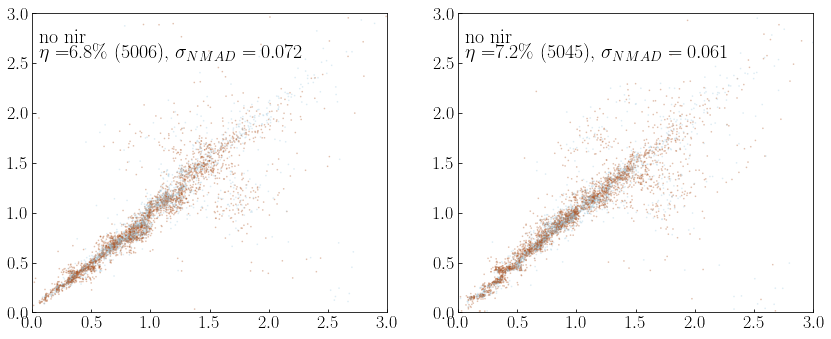

In [42]:
cat_allzG = Table.read(graham_output_dir+'pcat_small_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_C20added.fits')
cat_partialzG = Table.read(graham_output_dir+'pcat_small_zGnoirac_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_C20added.fits')
max_phot_err = 0.2

fig, axs = plt.subplots(1, 2, figsize = (14, 5.5))
for i,cat_matched in enumerate([cat_allzG,cat_partialzG]):
    cat_matched = cat_matched[cat_matched['lp_zPDF_2']>0]
    
    cond_U = ( (cat_matched['u'] > 0.) & (cat_matched['u'] < 50.) & (cat_matched['u_err'] > 0.) & (cat_matched['u_err'] < max_phot_err) )| \
         ( (cat_matched['uS'] > 0.) & (cat_matched['uS'] < 50.) & (cat_matched['uS_err'] > 0.) & (cat_matched['uS_err'] < max_phot_err) )
    cond_g = ( (cat_matched['g'] > 0.) & (cat_matched['g'] < 50.) & (cat_matched['g_err'] > 0.) & (cat_matched['g_err'] < max_phot_err) ) 
    cond_r = ( (cat_matched['r'] > 0.) & (cat_matched['r'] < 50.) & (cat_matched['r_err'] > 0.) & (cat_matched['r_err'] < max_phot_err) )
    cond_i = ( (cat_matched['i'] > 0.) & (cat_matched['i'] < 50.) & (cat_matched['i_err'] > 0.) & (cat_matched['i_err'] < max_phot_err) )
    cond_z = ( (cat_matched['z'] > 0.) & (cat_matched['z'] < 50.) & (cat_matched['z_err'] > 0.) & (cat_matched['z_err'] < max_phot_err) )
    cond_y = ( (cat_matched['y'] > 0.) & (cat_matched['y'] < 50.) & (cat_matched['y_err'] > 0.) & (cat_matched['y_err'] < max_phot_err) )
    flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)
    cond_Y = ( (cat_matched['Yv'] > 0.) & (cat_matched['Yv'] < 50.) & (cat_matched['Yv_err'] > 0.) & (cat_matched['Yv_err'] < max_phot_err) )
    cond_J = ( (cat_matched['J'] > 0.) & (cat_matched['J'] < 50.) & (cat_matched['J_err'] > 0.) & (cat_matched['J_err'] < max_phot_err) )
    cond_H = ( (cat_matched['H'] > 0.) & (cat_matched['H'] < 50.) & (cat_matched['H_err'] > 0.) & (cat_matched['H_err'] < max_phot_err) )
    cond_Ks = ( (cat_matched['Ks'] > 0.) & (cat_matched['Ks'] < 50.) & (cat_matched['Ks_err'] > 0.) & (cat_matched['Ks_err'] < max_phot_err) )
    flag_nir = cond_Y.astype(int) + cond_J.astype(int) + cond_H.astype(int) + cond_Ks.astype(int)
    cond_ch1 = ( (cat_matched['MAG_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH1_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH1_CORR'] < 0.5) )
    cond_ch2 = ( (cat_matched['MAG_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAG_AUTO_CH2_CORR'] < 50.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat_matched['MAGERR_AUTO_CH2_CORR'] < 0.5) )
    flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 

    flag_photoz = cat_matched['flag_photoz_2']==1  # internally consistent photoz within C20 catalog

    # only show galaxies with good photometry
    cond_filters = (flag_optical>2) & (flag_irac>=1)

    # COSMOS consistent photoz objects only
    cond = flag_photoz & cond_filters
    axs[i].scatter(cat_matched[cond]['lp_zPDF_2'], cat_matched[cond]['Z_COMBINE'],s=0.5,c=flag_irac[cond],alpha=0.3,cmap='Paired')
    axs[i].set_xlim([0,3])
    axs[i].set_ylim([0,3])
    
    # print out outlier fraction
    outlier_factor = 0.15
    num_outliers_15 = len(cat_matched[cond][abs(cat_matched[cond]['lp_zPDF_2']-cat_matched[cond][z_keyname])>outlier_factor*(1+cat_matched[cond]['lp_zPDF_2'])])
    deltaz = np.array(cat_matched[cond]['Z_COMBINE']-cat_matched[cond]['lp_zPDF_2'])
    sigma = 1.4826*np.median(abs(deltaz - np.median(deltaz)))
    axs[i].annotate('no nir',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[i].annotate('$\eta=$'+str(round(num_outliers_15/len(cat_matched[cond])*100,1))+'\% '+'('+str(len(flag_irac[cond]))+'), $\sigma_{NMAD}='+str(round(sigma,3))+'$',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')

#### Checks XMM-LSS catalog

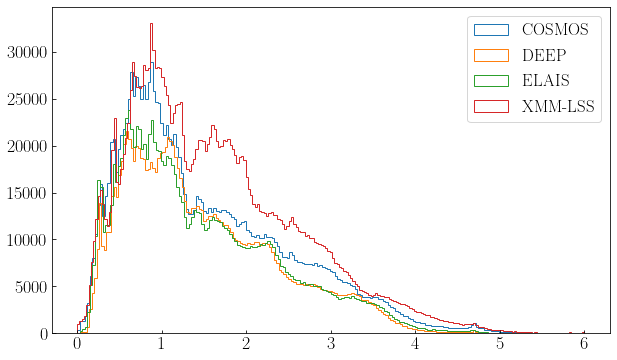

In [10]:
fig, axs = plt.subplots(1,1, figsize = (10, 6))
cat_xmm = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/pcat_XMM-LSS_deep_cat_out_nomaglimit_nonirirac_il_nz_prior_formass.fits')

for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
    cat_field = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/pcat_'+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits')
    plt.hist(cat_field['Z_COMBINE'],range=(0,6),bins='scott',histtype='step',label=cat_name.replace('_deep',''))
    
plt.hist(cat_xmm['Z_COMBINE'],range=(0,6),bins='scott',histtype='step',label='XMM-LSS')
plt.legend(fontsize=17)
plt.show()

(6.8, 12.5)

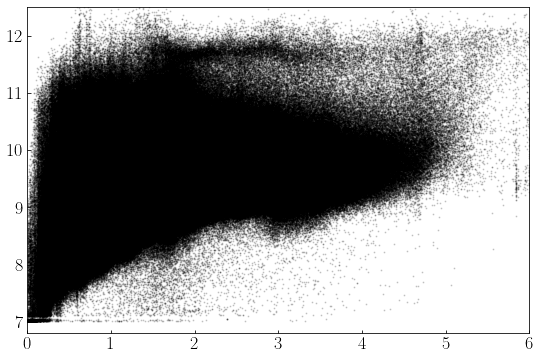

In [13]:
fig, axs = plt.subplots(1,1, figsize = (9, 6))

plt.scatter(cat_xmm['Z_COMBINE'],cat_xmm['MASS_MED_massrun'],s=1,color='k',alpha=0.15)
plt.xlim([0,6])
plt.ylim([6.8,12.5])

#### Mass check with C20

#### z-corrections

81971
0.2
0.5
0.8
1.1


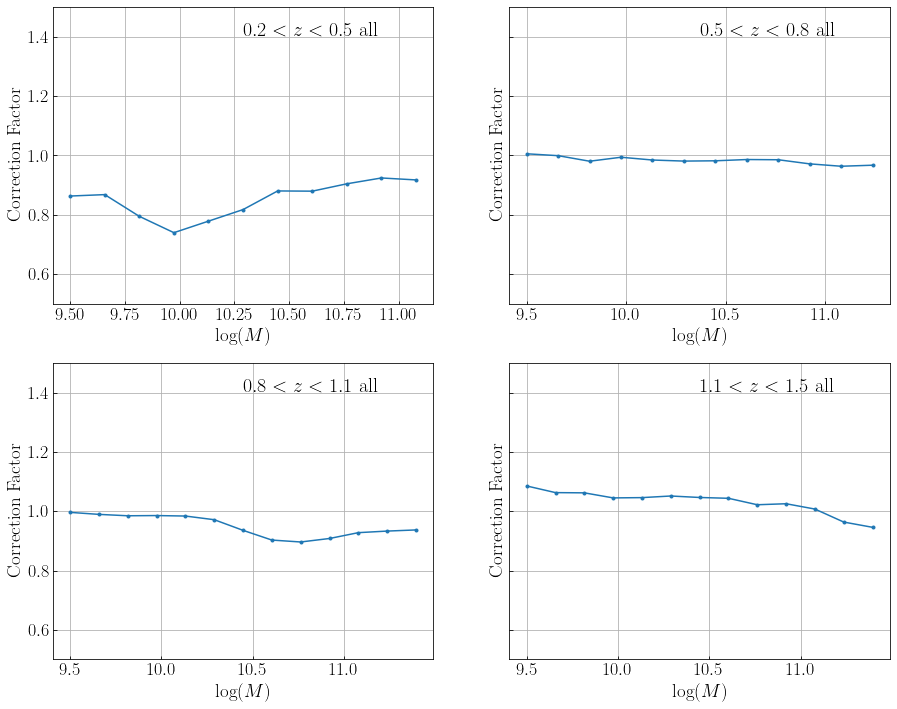

In [51]:
# outlier correction for number density
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
sfq = 'all'
zkeyname = 'ZPHOT_G_6B'
z_c20_keyname = 'lp_zPDF_farmer'

cat_name = cat_output_nonir_name
cat_output_c20added = Table.read(cat_name.replace('_sfq_added.fits','_c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added[z_c20_keyname]>0]
cat_output_c20added = cat_output_c20added[cat_output_c20added['i']<25]

flag_photoz = cat_output_c20added['flag_photoz']==1  # internally consistent photoz within C20 catalog
flag_optical = cat_output_c20added['flag_optical'] 
cond_filters = (flag_optical>4) 
cat_output_c20added = cat_output_c20added[flag_photoz & cond_filters]
# cat_output_c20added = cat_output_c20added[cond_filters]
print(len(cat_output_c20added))

if sfq == 'q':
    cat_output_c20added = cat_output_c20added[cat_output_c20added['sfq_nuvrk']==0]
elif sfq == 'sf':
    cat_output_c20added = cat_output_c20added[cat_output_c20added['sfq_nuvrk']==1]
else:
    pass

fig, axs = plt.subplots(2, 2, figsize = (15, 12), sharey=True)
mass_list = np.linspace(9.5, 12.5, 20)
min_gals = 100 # minimum number of galaxies in the bin to have a measurement
bin_size = 0.125
mode = 'failures only' # 'all outliers' or 'failures_only'
if mode == 'failures only':
    threshold = 0.15
    mode_show = mode + '('+ str(threshold) + ')'
else:
    threshold = ''
    mode_show = mode
    
time = datetime.now()
time = time.strftime("%y-%m-%d %H:%M")
#plt.suptitle('mode:'+mode_show+', bin size:'+str(bin_size)+', min. gals in bin:'+str(min_gals)+'\n'+time,fontsize=20)

for i in range(len(z_mins)):
    row = i//2
    col = i % 2
    mass_plot_list = []
    correction_list = []
    print(z_mins[i])
    for mass in mass_list:
        cond = abs(cat_output_c20added['MASS_MED_massrun']-mass)<bin_size
        cat_m_select = cat_output_c20added[cond]
        
        cat_true = cat_m_select[np.logical_and(cat_m_select[z_c20_keyname]>z_mins[i],cat_m_select[z_c20_keyname]<z_maxs[i])]
        cat_my_z = cat_m_select[np.logical_and(cat_m_select[zkeyname]>z_mins[i],cat_m_select[zkeyname]<z_maxs[i])]
        if mode == 'failures only':
            cat_correct = cat_my_z[np.logical_and(cat_my_z[z_c20_keyname]>z_mins[i],cat_my_z[z_c20_keyname]<z_maxs[i])]
            cat_interlopers = cat_my_z[abs(cat_my_z[z_c20_keyname]-cat_my_z[zkeyname])>threshold*(1+cat_my_z[zkeyname])]
            cat_missing = cat_true[abs(cat_true[z_c20_keyname]-cat_true[zkeyname])>threshold*(1+cat_true[z_c20_keyname])]
            cat_outliers = cat_true[abs(cat_true[z_c20_keyname] - cat_true[zkeyname])>threshold*(1+cat_true[z_c20_keyname])]
        
        if len(cat_true)>min_gals and len(cat_my_z)>min_gals:
            mass_plot_list.append(mass)
            if mode == 'all outliers':
                correction_list.append(len(cat_true)/len(cat_my_z))
            else:
                correction_list.append((len(cat_correct)+len(cat_missing))/(len(cat_correct)+len(cat_interlopers)))

    axs[row][col].plot(mass_plot_list,correction_list,'.-')
    axs[row][col].set_xlabel(r'$\log(M)$',fontsize=19)
    axs[row][col].set_ylabel('Correction Factor',fontsize=19)
    axs[row][col].grid(True)
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$ '+sfq,xy=([0.5,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[row][col].set_ylim([0.5,1.5])
    
    # save to disc
    corr_factor = np.vstack([mass_plot_list,np.array(correction_list)])
    np.save('pcat_outlier_corr_frac_'+sfq+'_'+str(z_mins[i])+'.npy',corr_factor)
    
    # fit polynomial
    # coeff = np.polyfit(mass_plot_list,correction_list,3)
    # x_corr = np.linspace(mass_plot_list[0],mass_plot_list[-1],100)
    # y_corr = coeff[0]*x_corr**3+coeff[1]*x_corr**2+coeff[2]*x_corr+coeff[3]
    # axs[row][col].plot(x_corr, y_corr, color='r',alpha=0.5)
    # corr_factor_smooth = np.vstack([x_corr,y_corr])
    # np.save('pcat_outlier_corr_frac_'+sfq+'_'+str(z_mins[i])+'_smooth.npy',corr_factor_smooth)
    

#### mass corrections

In [4]:
def percentile_16(arr):
    return np.percentile(arr,16)

def percentile_84(arr):
    return np.percentile(arr,84)


median dM's
0.2<z<0.5 dM=0.01 , massive dM=0.15 21

median dM's
0.5<z<0.8 dM=-0.02 , massive dM=0.04 42

median dM's
0.8<z<1.1 dM=-0.04 , massive dM=0.19 58

median dM's
1.1<z<1.5 dM=-0.09 , massive dM=0.13 58



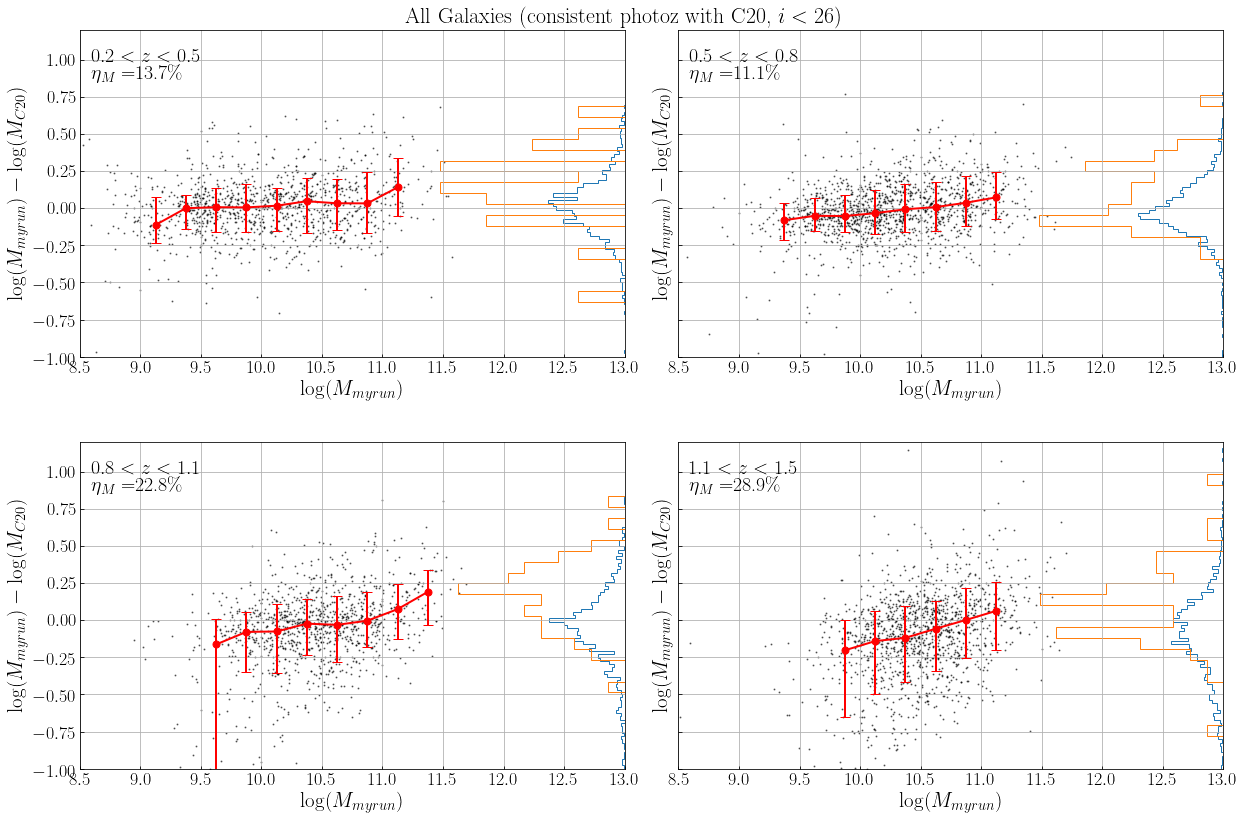

In [31]:
cat_name = cat_output_nonir_name
z_c20_keyname = 'lp_zPDF_farmer'
mass_c20_keyname = 'lp_mass_med_farmer'
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
sfq_show = 'all' # 'all' or 'split'
zkeyname = 'Z_COMBINE'


fig, axs = plt.subplots(2, 2, figsize = (18, 12), sharey=True)
cat_output_c20added = Table.read(cat_name.replace('_sfq_added.fits','_c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added[z_c20_keyname]>0]

for i,z_min in enumerate(z_mins):
    row = i // 2; col = i % 2
    cat_z = cat_output_c20added[cat_output_c20added[zkeyname]>z_mins[i]]
    cat_z = cat_z[cat_z[zkeyname]<z_maxs[i]]
    flag_photoz = cat_z['flag_photoz']==1  
    fig_title = 'All Galaxies (consistent photoz with C20, $i<26$)'
    
    flag_optical = cat_z['flag_optical'] 
    flag_irac = cat_z['flag_irac'] 
        
    # only show galaxies with good photo
    cond_filters = (flag_optical>3) & (flag_irac>=1)
            
    # COSMOS consistent photoz objects only
    cond_photoz_match = abs(cat_z[zkeyname] - cat_z[z_c20_keyname])<0.3*(1+cat_z[z_c20_keyname])
    cond =  cond_filters #& flag_photoz #& cond_photoz_match
    cat_z = cat_z[cond]
    
    if sfq_show == 'split':
        colors = ['b','r']
        for k,sfq in enumerate(['sf','q']):
            if sfq == 'q':
                cat_tmp = cat_z[cat_z['sfq_nuvrk_myrun_free']==0]
            else:
                cat_tmp = cat_z[cat_z['sfq_nuvrk_myrun_free']==1]
       
            # data to plot
            cat_tmp = cat_tmp[cat_tmp['MASS_MED_massrun']>0]
            cat_tmp = cat_tmp[cat_tmp[mass_c20_keyname]>0]
            x = np.array(cat_tmp['MASS_MED_massrun'])
            y = np.array(cat_tmp['MASS_MED_massrun'] - cat_tmp[mass_c20_keyname])
            y_massive_gal = y[cat_tmp['MASS_MED_massrun']>11.2]
    
            # plot
            im = axs[row][col].scatter(x,y,s=1,c=colors[k],alpha=0.5)
    
            # running median
            step = 0.2
            m_low = 8.0
            m_high = 12.2
            counts,bin_edges,bin_numbers = binned_statistic(x, y, statistic='count', bins=np.arange(m_low,m_high,step))
            medians,bin_edges,bin_numbers = binned_statistic(x, y, statistic='median', bins=np.arange(m_low,m_high,step))
            per16,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_16, bins=np.arange(m_low,m_high,step))
            per84,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_84, bins=np.arange(m_low,m_high,step))
            
            bin_centers = bin_edges[:-1]+step/2
            medians = medians[counts>10]
            bin_centers = bin_centers[counts>10]
            per16 = per16[counts>10]
            per84 = per84[counts>10]
            axs[row][col].errorbar(bin_centers, medians, yerr=[medians-per16,per84-medians],fmt='o-',color=colors[k],linewidth=2,capsize=5,markersize=7)
            np.save('mass_err/mass_err_median_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i]),np.array((bin_centers,medians,(per84-per16)/2)))
    
    else:
        # data to plot
        cat_tmp = cat_z
        cat_tmp = cat_tmp[cat_tmp['MASS_MED_massrun']>0]
        cat_tmp = cat_tmp[cat_tmp[mass_c20_keyname]>0]
        x = np.array(cat_tmp['MASS_MED_massrun'])
        y = np.array(cat_tmp['MASS_MED_massrun'] - cat_tmp[mass_c20_keyname])
        y_massive_gal = y[cat_tmp['MASS_MED_massrun']>11.2]
    
        # plot
        im = axs[row][col].scatter(x,y,s=1,c='k',alpha=0.5)
    
        # running median
        step = 0.25
        m_low = 8.0
        m_high = 12.2
        counts,bin_edges,bin_numbers = binned_statistic(x, y, statistic='count', bins=np.arange(m_low,m_high,step))
        medians,bin_edges,bin_numbers = binned_statistic(x, y, statistic='median', bins=np.arange(m_low,m_high,step))
        per16,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_16, bins=np.arange(m_low,m_high,step))
        per84,bin_edges,bin_numbers = binned_statistic(x, y, statistic=percentile_84, bins=np.arange(m_low,m_high,step))
        
        min_count = 40
        bin_centers = bin_edges[:-1]+step/2
        medians = medians[counts>min_count]
        bin_centers = bin_centers[counts>min_count]
        per16 = per16[counts>min_count]
        per84 = per84[counts>min_count]
        
        axs[row][col].errorbar(bin_centers,medians,yerr=[medians-per16,per84-medians],fmt='o-',color='r',linewidth=2,capsize=5,markersize=7)
    
        # histogram for delta_M
        axs[row][col].hist(y,bins=100,range=(-1,1.2),orientation='horizontal',weights=-10*np.ones(len(y))/len(y),bottom=13,histtype='step')
        axs[row][col].hist(y_massive_gal,bins=30,range=(-1,1.2),orientation='horizontal',weights=-8*np.ones(len(y_massive_gal))/len(y_massive_gal),bottom=13,histtype='step')
        print("median dM's")
        print(str(z_mins[i])+'<z<'+str(z_maxs[i]),'dM='+str(round(np.median(y),2)),', massive dM='+str(round(np.median(y_massive_gal),2)),str(len(y_massive_gal)))
        print()
        np.save('mass_err/mass_err_median_all_'+str(z_mins[i])+'_'+str(z_maxs[i]),np.array((bin_centers, medians ,(per84-per16)/2)))
            
    axs[row][col].set_xlabel(r'$\log(M_{myrun})$',fontsize=21)
    axs[row][col].set_ylabel(r'$\log(M_{myrun}) - \log(M_{C20})$',fontsize=21)
    axs[row][col].set_xlim([8.5,13])
    axs[row][col].set_ylim([-1,1.2])
    axs[row][col].grid()
        
    # print out mass outlier fraction
    outlier_factor = 0.3
    num_outliers = len(cat_z[abs(cat_z['MASS_MED_massrun'] - cat_z[mass_c20_keyname])>outlier_factor])
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.02,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[row][col].annotate('$\eta_{M}=$'+str(round(num_outliers/len(cat_z)*100,1))+'\% ',xy=([0.02,0.84]),xycoords='axes fraction',fontsize=20,color='k')
     
    # cbar = fig.colorbar(im, ax=axs[row][col])
    # cbar.ax.set_ylabel(flag_name_list[i],fontsize=19)
    
plt.suptitle(fig_title,fontsize=22)
plt.tight_layout(pad=4, w_pad=2)

#### dz/dM plots

In [96]:
cat_output_nonir_name = dev_path + 'graham_output_cats_apermag/'+'pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits'

all
massive


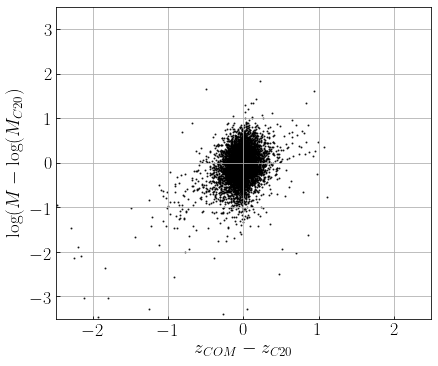

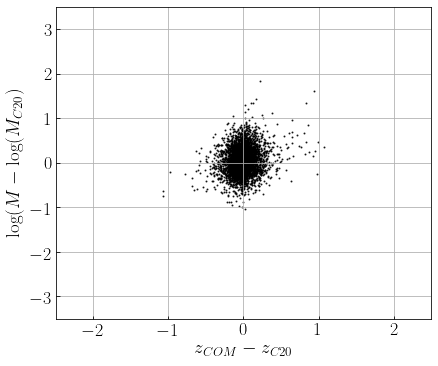

In [64]:

massive_cut=10.5

c20_type = 'lp' # ez or lp
if c20_type == 'lp':
    c20_zkeyname = 'lp_zPDF_farmer'
    c20_mkeyname = 'lp_mass_med_farmer'
else:
    c20_zkeyname = 'ez_z500_farmer'
    c20_mkeyname = 'log_ez_mass_p500_farmer'
    
for selection in ['all','massive']:
    print(selection)
    fig, axs = plt.subplots(1, 1, figsize = (7, 6))
    cat_output_c20added = Table.read(cat_output_nonir_name.replace('_sfq_added.fits','_c20added.fits'))
    cat_output_c20added = cat_output_c20added[cat_output_c20added[c20_zkeyname]>0]
        
    # flags
    flag_photoz = cat_output_c20added['flag_photoz']==1  
    flag_optical = cat_output_c20added['flag_optical'] 
    flag_irac = cat_output_c20added['flag_irac'] 
    flag_nir = cat_output_c20added['flag_nir'] 
    
    if selection == 'massive':
        cond = cat_output_c20added['MASS_MED_massrun']>massive_cut
    else:
        cond = np.ones(len(cat_output_c20added)).astype(bool)
    cond_filters = (flag_optical>2) & (flag_irac>=1)
    
    # COSMOS consistent photoz objects only
    cond = cond & flag_photoz & cond_filters
    
    x = cat_output_c20added[cond]['Z_COMBINE']-cat_output_c20added[cond][c20_zkeyname]
    y = cat_output_c20added[cond]['MASS_MED_massrun']-cat_output_c20added[cond][c20_mkeyname]
    im = axs.scatter(x,y,s=1,c='k',alpha=0.8,cmap='Paired')
    axs.set_xlim([-2.5,2.5])
    axs.set_ylim([-3.5,3.5])
        
    axs.set_xlabel(r'$z_{COM}- z_{C20}$',fontsize=19)
    axs.set_ylabel(r'$\log(M - \log(M_{C20})$',fontsize=19)
    axs.grid()
    
    plt.tight_layout(pad=4, w_pad=-1)



#### fitting mass errors

In [52]:
from scipy.optimize import curve_fit

def gaussian(x, a, mu, sigma):
    return a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def gau_lor(x, z, c, a ,mu, sigma):
    tau = c*(1+z)
    lor =  tau/(2*np.pi)*(1/((tau/2)**2+x**2))
    gau = a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
    return lor * gau

In [60]:
detect_limit = '_nolimit'
sfq = 'q'

cat_output_c20added = Table.read(cat_name.replace('_sfq_added.fits','c20added.fits'))
cat_output_c20added = cat_output_c20added[cat_output_c20added['lp_zPDF']>0]
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]

for i,z_min in enumerate(z_mins):
    z_max = z_maxs[i]
    cat_z = cat_output_c20added[cat_output_c20added['Z_COMBINE']>z_min]
    cat_z = cat_z[cat_z['Z_COMBINE']<z_max]
    flag_photoz = cat_z['flag_photoz']==1  
    fig_title = 'All Galaxies (consistent photoz with C20, $i<26$)'
    
    # only show galaxies with good photo
    flag_optical = cat_z['flag_optical'] 
    flag_irac = cat_z['flag_irac'] 
    cond_filters = (flag_optical>3) & (flag_irac>=2)
            
    # COSMOS consistent photoz objects only
    cond_photoz_match = abs(cat_z['Z_COMBINE'] - cat_z['lp_zPDF'])<0.15*(1+cat_z['lp_zPDF'])
    cond =  cond_filters & flag_photoz & cond_photoz_match
    # cond =  flag_photoz & cond_photoz_match
    cat_z = cat_z[cond]
    
    if sfq == 'q':
        cat_z = cat_z[cat_z['sfq_nuvrk_myrun_free']==0]
    elif sfq == 'sf':
        cat_z = cat_z[cat_z['sfq_nuvrk_myrun_free']==1]
    
    mass_bin_size = 1.0
    mass_bin_mins = np.arange(8,12.0,mass_bin_size)
    mass_mu_list = []
    mass_sigma_list = []
    for k,mass_min in enumerate(mass_bin_mins):
        mass_max = mass_min + mass_bin_size
        cat_z_mass = cat_z[np.logical_and(cat_z['MASS_MED_massrun']>mass_min,cat_z['MASS_MED_massrun']<mass_max)]
        if len(cat_z_mass)<=150:
            bin_enlarge = 0.15
            while len(cat_z_mass)<=150:
                cat_z_mass = cat_z[np.logical_and(cat_z['MASS_MED_massrun']>mass_min-bin_enlarge,cat_z['MASS_MED_massrun']<mass_max+bin_enlarge)]
                n,bins = np.histogram(y, bins=50, range=(-0.7,0.7))
                bin_enlarge += 0.1
        
        # Fitting mass error distribution
        mass_diff = np.array(cat_z_mass['MASS_MED_massrun'] - cat_z_mass['lp_mass_med'])
        mass_diff[np.isnan(mass_diff)]=-99
    
        # Gaussian fit
        n,bins = np.histogram(mass_diff, bins=50, range=(-0.7,0.7))
        popt,pcov = curve_fit(gaussian, bins[:-1]+(bins[1]-bins[0])/2, n,p0=[100,0,0.1])
            
        # mass error
        mass_mu_list.append(popt[1])
        mass_sigma_list.append(popt[2])
    
    # add the right bound
    mass_bin_centers = mass_bin_mins + mass_bin_size/2
    mass_err_list = np.stack([mass_bin_centers, mass_mu_list, mass_sigma_list])
    np.save('mass_err/pcat_mass_err_myrun_'+str(sfq)+'_'+str(z_min)+'.npy',mass_err_list)
    print(str(z_min)+'<z<'+str(z_max))
    print(mass_err_list)
    print('')


0.2<z<0.5
[[ 8.5    9.5   10.5   11.5  ]
 [ 0.073  0.073  0.075  0.061]
 [ 0.148  0.148  0.149  0.118]]

0.5<z<0.8
[[ 8.5    9.5   10.5   11.5  ]
 [ 0.028  0.028  0.041  0.087]
 [ 0.113  0.113  0.123  0.14 ]]

0.8<z<1.1
[[ 8.5    9.5   10.5   11.5  ]
 [ 0.032  0.032  0.046  0.102]
 [ 0.075  0.075  0.078  0.118]]

1.1<z<1.5
[[ 8.5    9.5   10.5   11.5  ]
 [ 0.013  0.013  0.043  0.154]
 [ 0.121  0.121  0.129  0.129]]



/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]


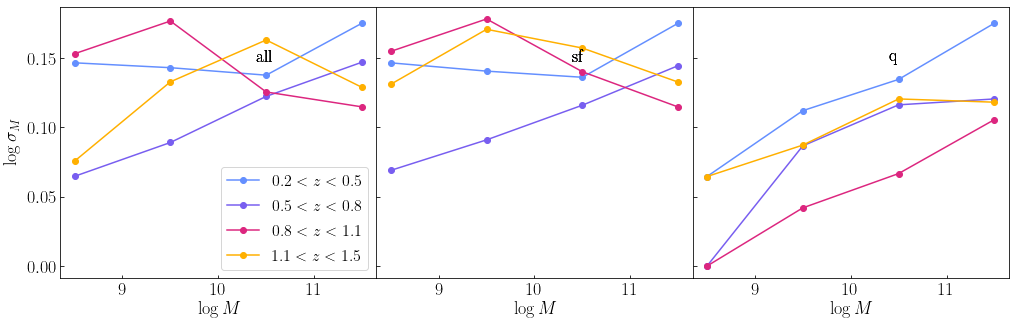

In [5]:
# remvove C20 errors
# (ignore mu's for now)
fig, axs = plt.subplots(1, 3, figsize = (17, 5),sharey=True)
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
colors = ['#648FFF','#785EF0','#DC267F','#FFB000']

for idx, sfq in enumerate(['all','sf','q']):
    for i,z_min in enumerate(z_mins):
        mass_errs_myrun = np.load('mass_err/pcat_mass_err_myrun_'+str(sfq)+'_'+str(z_min)+'.npy')
        mass_errs_C20 = np.load('mass_err/mass_err_C20_'+str(sfq)+'_'+str(z_min)+'.npy')

        err = np.sqrt(mass_errs_myrun[2,:]**2-mass_errs_C20[2,:]**2)
        if i==0:
            err[3]=0.175
        err[np.isnan(err)]=0
        axs[idx].plot(mass_errs_myrun[0,:],err,'o-',label='$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',color=colors[i])
        axs[idx].annotate(sfq,xy=([0.62,0.8]),xycoords='axes fraction',fontsize=17,color='k')
    
        np.save('mass_err/pcat_mass_err_overall_'+str(sfq)+'_'+str(z_min)+'.npy',np.vstack([mass_errs_myrun[0,:],err]))
    
    axs[idx].set_xlabel('$\log M$',fontsize=18)
    axs[0].set_ylabel('$\log \sigma_M$',fontsize=18)
    axs[0].legend(fontsize=16)

fig.subplots_adjust(wspace=0)


#### Field difference

z distribution 
mass distribution

In [26]:
cat_cosmos = Table.read(graham_output_dir+'pcat_COSMOS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
cat_cosmos = cat_cosmos[cat_cosmos['inside_hsc']==True]
cat_cosmos = cat_cosmos[cat_cosmos['isCompact']==False]
cat_cosmos = cat_cosmos[cat_cosmos['snr_i']>5]
cat_cosmos = cat_cosmos[cat_cosmos['snr_g']>3]
cat_cosmos = cat_cosmos[cat_cosmos['snr_u']>3]

cat_elais = Table.read(graham_output_dir+'pcat_ELAIS_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
cat_elais = cat_elais[cat_elais['inside_hsc']==True]
cat_elais = cat_elais[cat_elais['isCompact']==False]
cat_elais = cat_elais[cat_elais['snr_i']>5]
cat_elais = cat_elais[cat_elais['snr_g']>3]
cat_elais = cat_elais[cat_elais['snr_u']>3]

cat_deep = Table.read(graham_output_dir+'pcat_DEEP_deep_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
cat_deep = cat_deep[cat_deep['inside_hsc']==True]
cat_deep = cat_deep[cat_deep['isCompact']==False]
cat_deep = cat_deep[cat_deep['snr_i']>5]
cat_deep = cat_deep[cat_deep['snr_g']>3]
cat_deep = cat_deep[cat_deep['snr_u']>3]


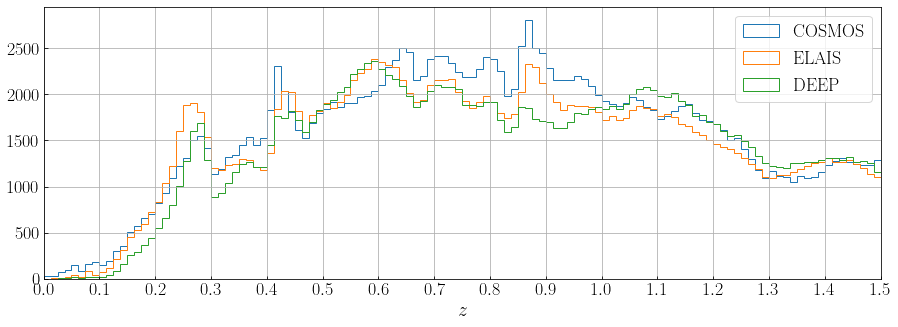

In [35]:
fig, axs = plt.subplots(1, 1, figsize = (15, 5),sharey=True)
axs.xaxis.set_major_locator(MultipleLocator(0.1)) # interval

plt.hist(cat_cosmos['Z_COMBINE'],histtype='step',weights=np.ones(len(cat_cosmos))/4.3,range=(0,1.5),bins=120,label='COSMOS')
plt.hist(cat_elais['Z_COMBINE'],histtype='step',weights=np.ones(len(cat_elais))/3.72,range=(0,1.5),bins=120,label='ELAIS')
plt.hist(cat_deep['Z_COMBINE'],histtype='step',weights=np.ones(len(cat_deep))/3.69,range=(0,1.5),bins=120,label='DEEP')

plt.xlim([0,1.5])
plt.xlabel('$z$',fontsize=20)
plt.legend(fontsize=18)
plt.grid()
plt.show()


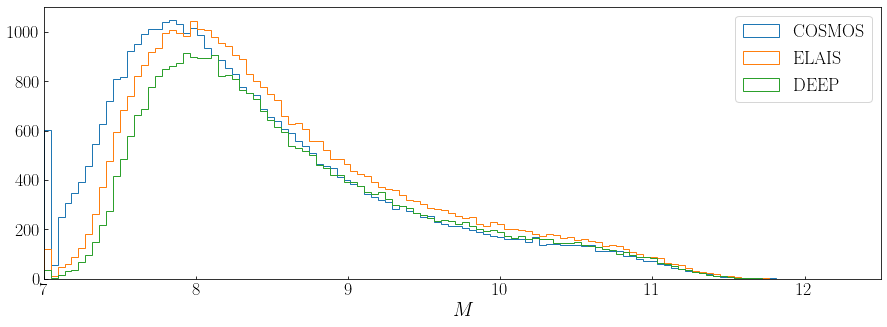

In [106]:
z_cut = 0.5
cat_cosmos_z = cat_cosmos[cat_cosmos['Z_COMBINE']<z_cut]
cat_elais_z = cat_elais[cat_elais['Z_COMBINE']<z_cut]
cat_deep_z = cat_deep[cat_deep['Z_COMBINE']<z_cut]

fig, axs = plt.subplots(1, 1, figsize = (15, 5),sharey=True)
plt.hist(cat_cosmos_z['MASS_MED_massrun'],histtype='step',weights=np.ones(len(cat_cosmos_z))/4.3,range=(7,12.5),bins=120,label='COSMOS')
plt.hist(cat_elais_z['MASS_MED_massrun'],histtype='step',weights=np.ones(len(cat_elais_z))/3.72,range=(7,12.5),bins=120,label='ELAIS')
plt.hist(cat_deep_z['MASS_MED_massrun'],histtype='step',weights=np.ones(len(cat_deep_z))/3.69,range=(7,12.5),bins=120,label='DEEP')

plt.xlim([7,12.5])
plt.xlabel('$M$',fontsize=20)
plt.legend(fontsize=18)
plt.show()

#### XMM checks

In [ ]:
cat_xmm = Table.read(graham_output_dir+'pcat_XMM-LSS_deep_cat_out_nomaglimit_noirac_il_nz_prior_formass.fits')

cat_xmm_z1 = cat_xmm[np.logical_and(cat_xmm['Z_COMBINE']>0.2,cat_xmm['Z_COMBINE']<0.8)]
cat_xmm_z2 = cat_xmm[np.logical_and(cat_xmm['Z_COMBINE']>0.8, cat_xmm['Z_COMBINE']<1.5)]

print(len(cat_xmm_z1[cat_xmm_z1['J']>10]),len(cat_xmm_z1),round(len(cat_xmm_z1[cat_xmm_z1['J']>10])/len(cat_xmm_z1),3))
print(len(cat_xmm_z2[cat_xmm_z2['J']>10]),len(cat_xmm_z2),round(len(cat_xmm_z2[cat_xmm_z2['J']>10])/len(cat_xmm_z2),3))

190082 389509 0.488
249990 540705 0.462


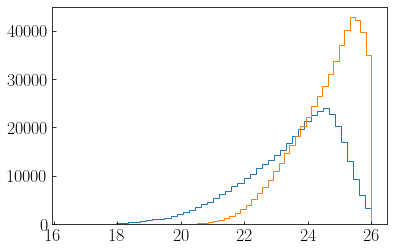

In [22]:
plt.hist(cat_xmm_z1['i'],bins=50,histtype='step')
plt.hist(cat_xmm_z2['i'],bins=50,histtype='step')
plt.show()

#### check mass/z uncertainty from SED fitting

In [32]:
cat_name = 'ELAIS'
cat_test = Table.read('pcat_'+cat_name+'_zerr_merr.fits')
print(cat_test.info)

<Table length=1258066>
       name        dtype 
----------------- -------
               ID   int64
               RA float64
              DEC float64
          ZPHOT_G float64
          i_aper3 float64
                u float64
                g float64
                r float64
                i float64
                z float64
                y float64
 MASS_MED_massrun float64
 MASS_INF_massrun float64
MASS_BEST_massrun float64
 MASS_SUP_massrun float64
          Z_LOW68 float64
         Z_HIGH68 float64
            Z_CHI float64
           Z_PEAK float64



Text(0, 0.5, '$z_{high}-z_{low}$')

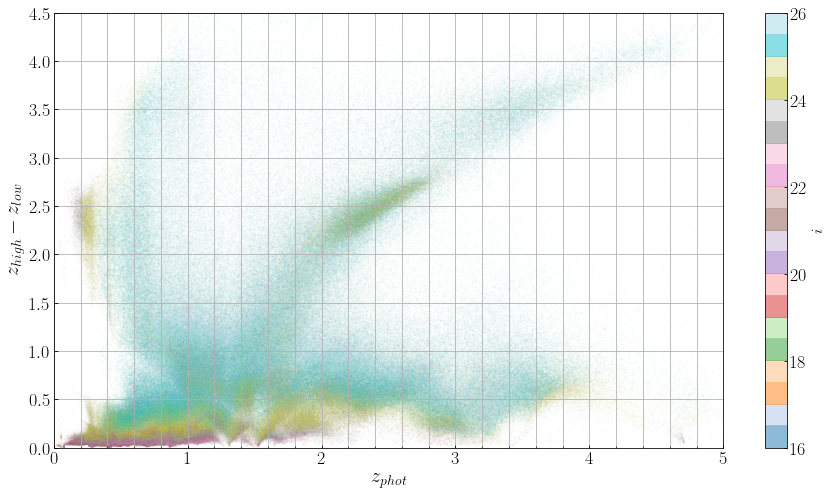

In [33]:
fig, axs = plt.subplots(1, 1, figsize = (15, 8),sharey=True)
axs.xaxis.set_major_locator(MultipleLocator(1)) # interval
axs.xaxis.set_minor_locator(MultipleLocator(0.2)) # interval

im=plt.scatter(cat_test['ZPHOT_G'],cat_test['Z_HIGH68']-cat_test['Z_LOW68'],s=0.002,alpha=0.5,c=cat_test['i'],vmin=16,vmax=26,cmap='tab20')
cbar = fig.colorbar(im, ax=axs)
cbar.ax.set_ylabel('$i$',fontsize=16)
plt.xlim([0,5])
plt.ylim([0,4.5])

plt.grid(b=True,which='both')
plt.xlabel('$z_{phot}$',fontsize=20)
plt.ylabel('$z_{high}-z_{low}$',fontsize=20)

In [36]:
cat_test_0205 = cat_test[np.logical_and(cat_test['ZPHOT_G']>0.2,cat_test['ZPHOT_G']<0.5)]
cat_test_largezerr = cat_test_0205[cat_test_0205['Z_HIGH68']-cat_test_0205['Z_LOW68']>0.5]
print(len(cat_test_largezerr),len(cat_test_0205),round(len(cat_test_largezerr)/len(cat_test_0205),4))

20851 138355 0.1507


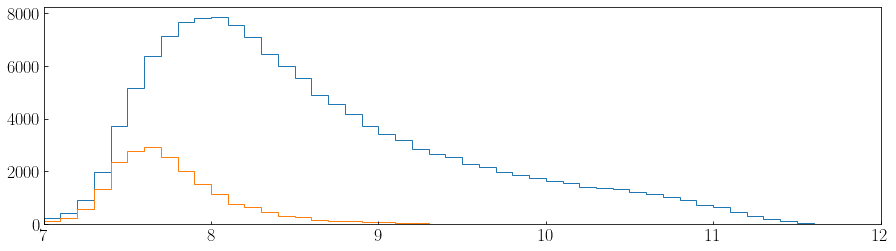

In [37]:
fig, axs = plt.subplots(1, 1, figsize = (15, 4),sharey=True)
plt.hist(cat_test_0205['MASS_MED_massrun'],range=(7,12),histtype='step',bins=50)
plt.hist(cat_test_largezerr['MASS_MED_massrun'],range=(7,12),histtype='step',bins=50)
plt.xlim([7,12])
plt.show()

Text(0, 0.5, '$M_{high}-M_{low}$')

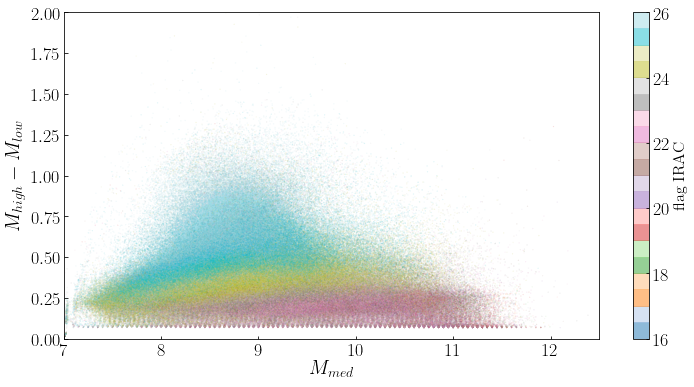

In [29]:
fig, axs = plt.subplots(1, 1, figsize = (12, 6),sharey=True)
cat_test_lowz = cat_test[cat_test['ZPHOT_G']<1.5]

im=plt.scatter(cat_test_lowz['MASS_MED_massrun'],cat_test_lowz['MASS_SUP_massrun']-cat_test_lowz['MASS_INF_massrun'],s=0.01,alpha=0.5,c=cat_test_lowz['i'],vmin=16,vmax=26,cmap='tab20')
cbar = fig.colorbar(im, ax=axs)
cbar.ax.set_ylabel('flag IRAC',fontsize=16)
plt.xlim([7,12.5])
plt.ylim([0,2])

plt.xlabel('$M_{med}$',fontsize=20)
plt.ylabel('$M_{high}-M_{low}$',fontsize=20)

#### IRAC detected objects ... z_G better?
pcat catalogs on central COSMOS

In [44]:
cat_zG_check = Table.read(graham_output_dir+'pcat_zGmass_check_08squdeg_nonir.fits')

In [45]:
cond_ch1 = ((cat_zG_check['MAG_AUTO_CH1_CORR'] > 0.) & (cat_zG_check['MAG_AUTO_CH1_CORR'] < 50.) & (cat_zG_check['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat_zG_check['MAGERR_AUTO_CH1_CORR'] < 0.5))
cond_ch2 = ((cat_zG_check['MAG_AUTO_CH2_CORR'] > 0.) & (cat_zG_check['MAG_AUTO_CH2_CORR'] < 50.) & (cat_zG_check['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat_zG_check['MAGERR_AUTO_CH2_CORR'] < 0.5))
flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int)

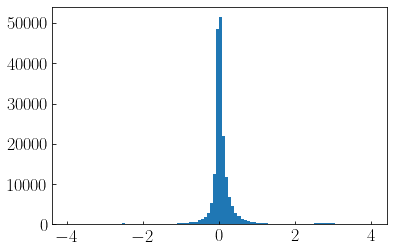

In [46]:
plt.hist(cat_zG_check['Z_COMBINE_noiracZG'] - cat_zG_check['lp_zPDF'],range=(-4,4),bins=100)
plt.show()

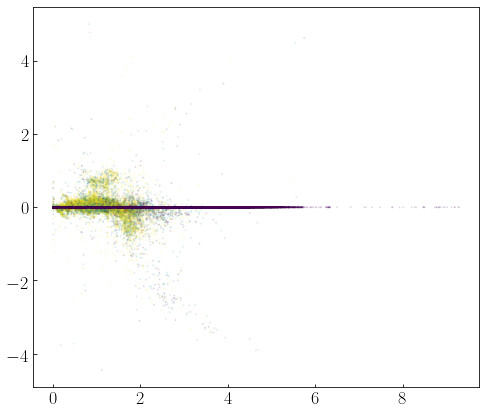

In [40]:
fig, axs = plt.subplots(1, 1, figsize = (8, 7),sharey=True)
plt.scatter(cat_zG_check['lp_zPDF'],cat_zG_check['Z_COMBINE_noiracZG'] -cat_zG_check['Z_COMBINE_allZG'],s=1,c=flag_irac,alpha=0.1)

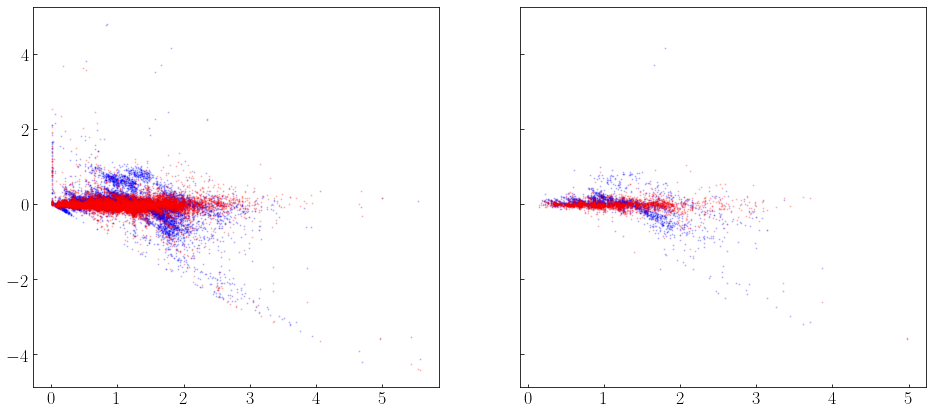

In [59]:
fig, axs = plt.subplots(1, 2, figsize = (16, 7),sharey=True)
cat_zG_check_irac = cat_zG_check[flag_irac>0]
axs[0].scatter(cat_zG_check_irac['lp_zPDF'],cat_zG_check_irac['Z_COMBINE_noiracZG']-cat_zG_check_irac['lp_zPDF'] ,s=1, c='b',alpha=0.2)
axs[0].scatter(cat_zG_check_irac['lp_zPDF'],cat_zG_check_irac['Z_COMBINE_allZG']-cat_zG_check_irac['lp_zPDF'] ,s=1,c='r',alpha=0.2)

cat_zG_check_irac_massive = cat_zG_check_irac[cat_zG_check_irac['lp_mass_med']>11.0]
axs[1].scatter(cat_zG_check_irac_massive['lp_zPDF'],cat_zG_check_irac_massive['Z_COMBINE_noiracZG']-cat_zG_check_irac_massive['lp_zPDF'] ,s=1, c='b',alpha=0.2)
axs[1].scatter(cat_zG_check_irac_massive['lp_zPDF'],cat_zG_check_irac_massive['Z_COMBINE_allZG']-cat_zG_check_irac_massive['lp_zPDF'] ,s=1,c='r',alpha=0.2)

(-5, 5)

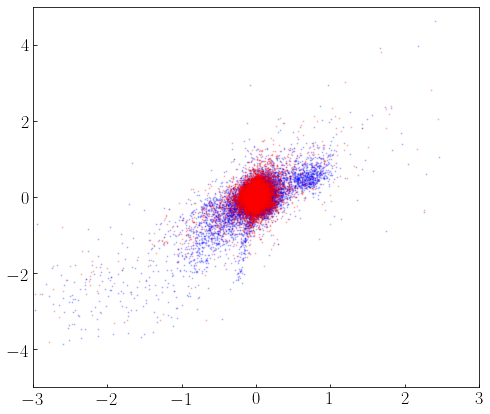

In [64]:
fig, axs = plt.subplots(1, 1, figsize = (8, 7),sharey=True)
axs.scatter(cat_zG_check_irac['Z_COMBINE_noiracZG'] - cat_zG_check_irac['lp_zPDF'], cat_zG_check_irac['MASS_MED_massrun_noiracZG']-cat_zG_check_irac['lp_mass_med'] ,s=1, c='b',alpha=0.2)
axs.scatter(cat_zG_check_irac['Z_COMBINE_allZG'] - cat_zG_check_irac['lp_zPDF'], cat_zG_check_irac['MASS_MED_massrun_allZG']-cat_zG_check_irac['lp_mass_med'] ,s=1,c='r',alpha=0.2)
axs.set_xlim([-3,3])
axs.set_ylim([-5,5])

#### auto_adapt checks

In [8]:
cat_nocorr = Table.read(graham_output_dir+'pcat_nocorr_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits')
cat_bc03 = Table.read(graham_output_dir+'pcat_BC03_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits')
cat_zcorr = Table.read(graham_output_dir+'pcat_photozcorr_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits')

In [9]:
cat_corr_combine  = cat_nocorr['ID','RA','DEC','Z_COMBINE','lp_zPDF','lp_mass_med','MASS_MED_massrun'].copy()
bc03_masscol = Column(data=cat_bc03['MASS_MED_massrun'], name='MASS_MED_massrun_bc03corr')
zcorr_masscol = Column(data=cat_zcorr['MASS_MED_massrun'], name='MASS_MED_massrun_zcorr')

cat_corr_combine.add_columns([bc03_masscol,zcorr_masscol])
cat_corr_combine.write('pcat_corr_compare_08squdeg_nonir_il_nz_prior_nolimit.fits', overwrite=True)

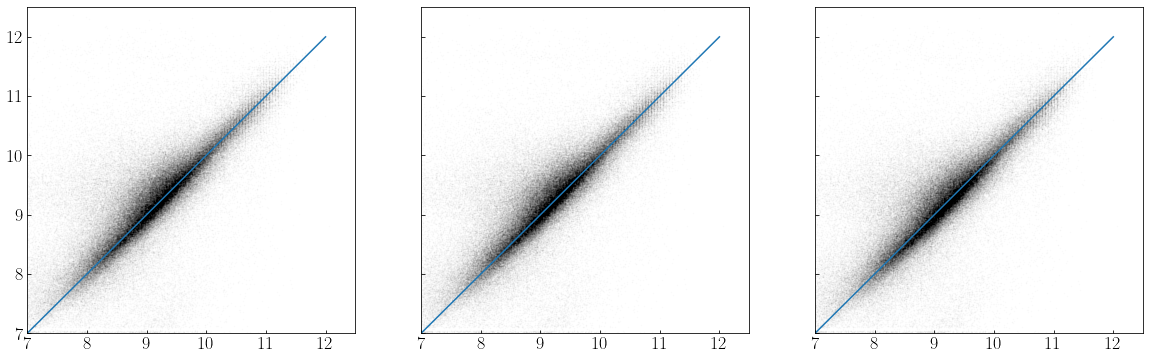

In [79]:
fig, axs = plt.subplots(1, 3, figsize = (20, 6),sharey=True)

axs[0].scatter(cat_corr_combine['lp_mass_med'],cat_corr_combine['MASS_MED_massrun'],s=0.3,color='k',alpha=0.02)
axs[0].plot([7,12],[7,12])
axs[0].set_xlim([7,12.5])
axs[0].set_ylim([7,12.5])

axs[1].scatter(cat_corr_combine['lp_mass_med'],cat_corr_combine['MASS_MED_massrun_bc03corr'],s=0.3,color='k',alpha=0.02)
axs[1].set_xlim([7,12.5])
axs[1].set_ylim([7,12.5])
axs[1].plot([7,12],[7,12])

axs[2].scatter(cat_corr_combine['lp_mass_med'],cat_corr_combine['MASS_MED_massrun_zcorr'],s=0.3,color='k',alpha=0.02)
axs[2].set_xlim([7,12.5])
axs[2].set_ylim([7,12.5])
axs[2].plot([7,12],[7,12])

(-2, 2)

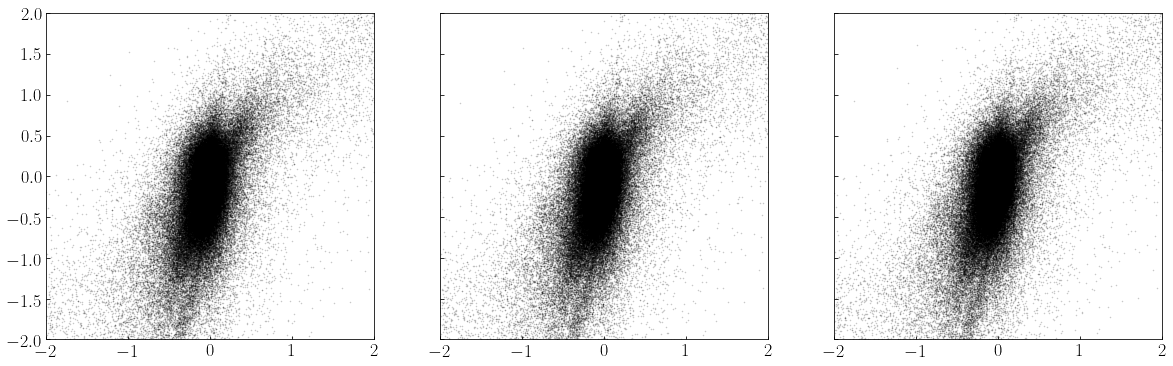

In [73]:
fig, axs = plt.subplots(1, 3, figsize = (20, 6),sharey=True)

axs[0].scatter(cat_corr_combine['lp_zPDF']-cat_corr_combine['Z_COMBINE'],cat_corr_combine['lp_mass_med']-cat_corr_combine['MASS_MED_massrun'],s=0.3,color='k',alpha=0.2)
axs[0].set_xlim([-2,2])
axs[0].set_ylim([-2,2])

axs[1].scatter(cat_corr_combine['lp_zPDF']-cat_corr_combine['Z_COMBINE'],cat_corr_combine['lp_mass_med']-cat_corr_combine['MASS_MED_massrun_bc03corr'],s=0.3,color='k',alpha=0.2)
axs[1].set_xlim([-2,2])
axs[1].set_ylim([-2,2])

axs[2].scatter(cat_corr_combine['lp_zPDF']-cat_corr_combine['Z_COMBINE'],cat_corr_combine['lp_mass_med']-cat_corr_combine['MASS_MED_massrun_zcorr'],s=0.3,color='k',alpha=0.2)
axs[2].set_xlim([-2,2])
axs[2].set_ylim([-2,2])

##### with and without detect limit in IRAC

check if including a detection limit changes mass accuracy\
both cases I use photoz from Guillaume's catalog

In [9]:
cat_nolimit = Table.read(graham_output_dir+'pcat_cat_out_08squdeg_nonir_il_nz_prior_nolimit_formass.fits')
cat_limit = Table.read(graham_output_dir+'pcat_cat_out_08squdeg_nonir_il_nz_prior_23.8_formass.fits')

# cut column
cat_nolimit_cutol = cat_nolimit['ID','RA','DEC','Z_ML','Z_COMBINE','MASS_MED_massrun','lp_zPDF','lp_mass_med','flag_photoz','u', 'uS', 
                                'g', 'r', 'i', 'z', 'y', 'Yv', 'J', 'H', 'Ks', 'ZPHOT_G', 'ZPHOT_6B_G', 'ZPHOT_NIR', 
                                'MAG_AUTO_CH1', 'MAGERR_AUTO_CH1', 'MAG_AUTO_CH2', 'MAGERR_AUTO_CH2', 'u_err', 
                                'uS_err', 'g_err', 'r_err', 'i_err', 'z_err', 'y_err', 'Yv_err', 'J_err', 'H_err', 'Ks_err', 
                                'MAG_AUTO_CH1_CORR', 'MAG_AUTO_CH2_CORR', 'MAGERR_AUTO_CH1_CORR', 'MAGERR_AUTO_CH2_CORR']
cat_limit_cutol = cat_limit['Z_COMBINE','Z_ML','MASS_MED_massrun']

cat_check_combine = hstack([cat_nolimit_cutol,cat_limit_cutol], table_names=['nolimit','limit'])
cat_check_combine.write(graham_output_dir+'pcat_cat_out_08squdeg_nonir_il_nz_prior_checkiraclimit.fits',overwrite=True)

add_photo_flag(graham_output_dir+'pcat_cat_out_08squdeg_nonir_il_nz_prior_checkiraclimit.fits')

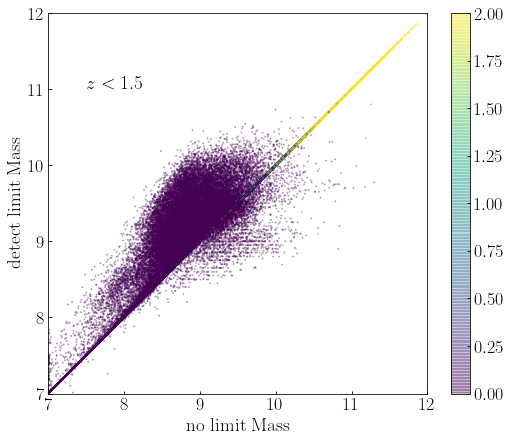

In [10]:
cat_check_combine = Table.read(graham_output_dir+'pcat_cat_out_08squdeg_nonir_il_nz_prior_checkiraclimit.fits')
cat_check_combine_z = cat_check_combine[np.logical_and(cat_check_combine['Z_COMBINE_nolimit']<1.5, cat_check_combine['ZPHOT_G']>0)]

fig, axs = plt.subplots(1, 1, figsize = (8.5, 7))
plt.scatter(cat_check_combine_z['MASS_MED_massrun_nolimit'],cat_check_combine_z['MASS_MED_massrun_limit'],s=1,c=cat_check_combine_z['flag_irac'],alpha=0.3)
plt.annotate('$z<1.5$',xy=([0.1,0.8]),xycoords='axes fraction',fontsize=19,color='k')
plt.xlabel('no limit Mass',fontsize=19)
plt.ylabel('detect limit Mass',fontsize=19)
plt.xlim([7,12])
plt.ylim([7,12])
plt.colorbar()

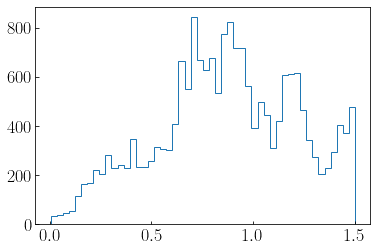

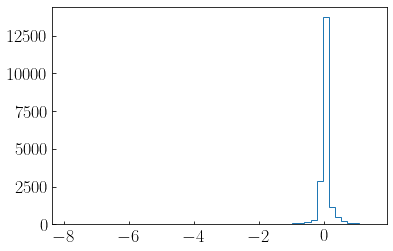

In [72]:
cat_check_mchange = cat_check_combine_z[abs(cat_check_combine_z['MASS_MED_massrun_nolimit']-cat_check_combine_z['MASS_MED_massrun_232limit'])>0.1]

plt.hist(cat_check_mchange['Z_COMBINE_nolimit'],bins=50,histtype='step')
plt.show()

plt.hist(cat_check_mchange['Z_COMBINE_nolimit']-cat_check_mchange['lp_zPDF'],bins=50,histtype='step')
plt.show()

#### Massive Gal Checks

In [11]:
cat_name = graham_output_dir+'pcat_cat_out_08squdeg_nonir_il_nz_prior_checkiraclimit.fits'
print(cat_name)
cat_check = Table.read(cat_name)

/Users/lejay/research/lephare_dev/my_code/graham_output_cats/pcat_cat_out_08squdeg_nonir_il_nz_prior_checkiraclimit.fits


In [22]:
# check massive gals
phot_config = 'nonir'
detect_limit = 'nolimit'

massive_cut=11.0
cond = cat_check['MASS_MED_massrun_'+detect_limit]>massive_cut # my massive
massive_gals_selected = cat_check[cond]

massive_gals_selected = massive_gals_selected[massive_gals_selected['Z_COMBINE_'+detect_limit]<1.5]
keys = [key for key in massive_gals_selected.keys() if 'MAGERR_APER' in key]
massive_gals_selected.remove_columns(keys)
    
massive_gals_selected.write('lp_massive_gal_check/pcat_massive_gal_check_centralCOSMOS.fits',overwrite=True)
print(len(massive_gals_selected))

2143


(array([   8.,    0.,    0.,   34.,    0.,    0.,  118.,    0.,    0.,
        1983.]),
 array([3. , 3.3, 3.6, 3.9, 4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. ]),
 <a list of 10 Patch objects>)

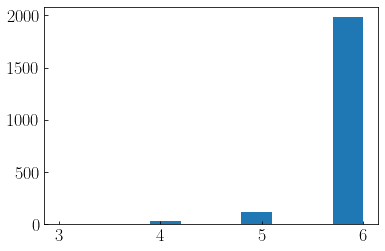

In [45]:
plt.hist(massive_gals_selected['flag_optical'])

2143 143 0.067
0.9575361642557163
2052 96 0.047


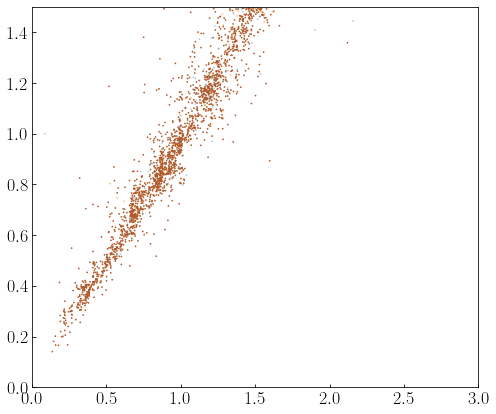

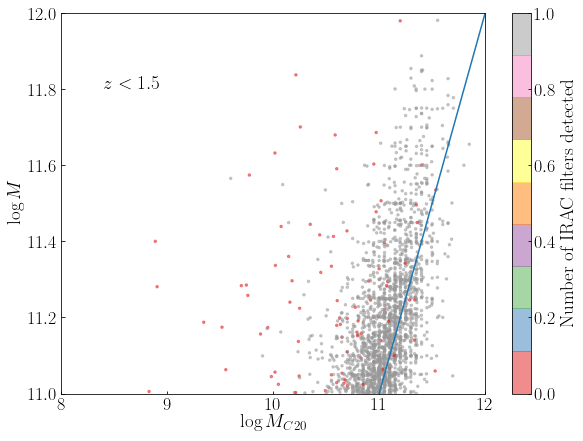

In [62]:
# z/mass/SFQ

fig, axs = plt.subplots(1, 1, figsize = (8, 7))
plt.scatter(massive_gals_selected['lp_zPDF'], massive_gals_selected['Z_COMBINE_'+detect_limit],s=0.5,alpha=2,c=massive_gals_selected['flag_irac'], cmap='Paired')
plt.xlim([0,3])
plt.ylim([0,1.5])

fig, axs = plt.subplots(1, 1, figsize = (9.5, 7))
fake_criteria = 1 - np.logical_or(massive_gals_selected['flag_irac']==0,massive_gals_selected['flag_optical']<4)
im = plt.scatter(massive_gals_selected['lp_mass_med'], massive_gals_selected['MASS_MED_massrun_'+detect_limit],s=6,alpha=0.5,c=fake_criteria,cmap='Set1',vmin=0,vmax=1)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Number of IRAC filters detected',fontsize=19)
plt.xlabel('$\log M_{C20}$',fontsize=19)
plt.ylabel('$\log M$',fontsize=19)
plt.annotate('$z<1.5$',xy=([0.1,0.8]),xycoords='axes fraction',fontsize=19,color='k')
plt.plot([0,12],[0,12])
plt.xlim([8,12])
plt.ylim([11.0,12])

# count outliers
all_outliers = massive_gals_selected[abs(massive_gals_selected['lp_mass_med'] - massive_gals_selected['MASS_MED_massrun_'+detect_limit])>0.5]
print(len(massive_gals_selected),len(all_outliers),round(len(all_outliers)/len(massive_gals_selected),3))

massive_gals_irac = massive_gals_selected[massive_gals_selected['flag_irac']>0]
irac_outliers = massive_gals_irac[abs(massive_gals_irac['lp_mass_med'] - massive_gals_irac['MASS_MED_massrun_'+detect_limit])>0.5]
print(len(massive_gals_irac)/len(massive_gals_selected))
print(len(massive_gals_irac),len(irac_outliers),round(len(irac_outliers)/len(massive_gals_irac),3))

20 22 0.909


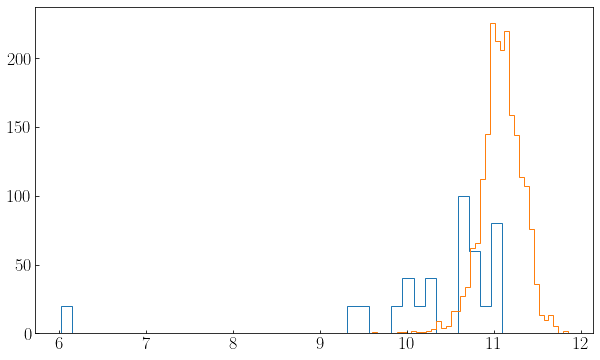

In [38]:
# true mass distribution of fake massive gals
fig, axs = plt.subplots(1, 1, figsize = (10, 6))
massive_gals_noirac = massive_gals_selected[np.logical_and(massive_gals_selected['flag_irac']==0,massive_gals_selected['flag_optical']<=5)]
fake_massive_gals = massive_gals_noirac[massive_gals_noirac['lp_mass_med']<11.0]
print(len(fake_massive_gals),len(massive_gals_noirac),round(len(fake_massive_gals)/len(massive_gals_noirac),3))

plt.hist(massive_gals_noirac['lp_mass_med'],bins=40, histtype='step',weights=20*np.ones(len(massive_gals_noirac)))
plt.hist(massive_gals_irac['lp_mass_med'],bins=40, histtype='step')
plt.show()

In [8]:
# IRAC mag distribution for C20 massive gals
c20_massive_cond = cat_output_c20added['lp_mass_med']>10.5
massive_gals_c20_selected = cat_output_c20added[c20_massive_cond]
    
keys = [key for key in massive_gals_c20_selected.keys() if 'MAGERR_APER' in key]
massive_gals_c20_selected.remove_columns(keys)
print(len(massive_gals_c20_selected))

11477


(array([1316.,    0.,    0.,    0.,    0., 1164.,    0.,    0.,    0.,
        8997.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

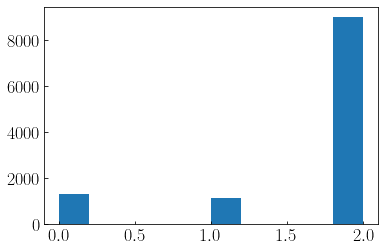

In [20]:
plt.hist(massive_gals_c20_selected['flag_irac'])

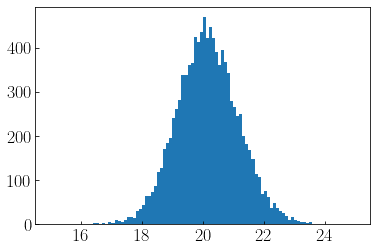

In [65]:
plt.hist(massive_gals_c20_selected['MAG_AUTO_CH1'],range=(15,25),bins=100)
plt.show()

0.1 20.067200469970707 10
0.24 19.406819534301757 65
0.37 19.993440246582033 113
0.51 19.895279693603516 94
0.64 20.036080169677735 230
0.78 20.157879638671876 180
0.91 20.35099983215332 245
1.05 20.56054000854492 187
1.19 20.819599151611328 244
1.32 21.095539474487303 263
1.46 21.146080017089844 128
1.59 21.301040267944337 103
1.73 21.453680419921874 56
1.86 21.59463958740234 31


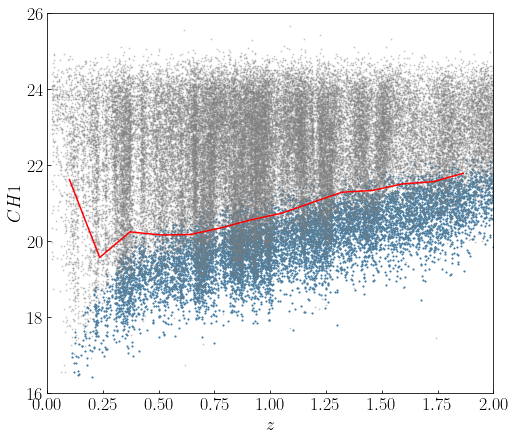

In [76]:
fig, axs = plt.subplots(1, 1, figsize = (8, 7))

z_edges = np.linspace(0.1,2.0,15)
mag_mins = []
for i in range(len(z_edges)-1):
    z_min = z_edges[i]
    z_max = z_edges[i+1]
    cat_masive_z = massive_gals_c20_selected[massive_gals_c20_selected['Z_ML']>z_min]
    cat_masive_z = cat_masive_z[cat_masive_z['Z_ML']<z_max]
    cat_masive_z = cat_masive_z[cat_masive_z['MAG_AUTO_CH1']>10]
    cat_masive_z = cat_masive_z[cat_masive_z['MAG_AUTO_CH1']<30]
    
    mag_cut20 = np.percentile(cat_masive_z['MAG_AUTO_CH1'],80)
    cat_z_lowmag =  cat_masive_z[ cat_masive_z['MAG_AUTO_CH1'] > mag_cut20]
    print(round(z_min,2),mag_cut20,len(cat_z_lowmag))
    mag_lims = cat_z_lowmag['MAG_AUTO_CH1'] + 2.5*(cat_z_lowmag['lp_mass_med']-10.5)
    mag_min =  np.percentile(mag_lims,5)
    mag_mins.append(mag_min)
    
plt.scatter(massive_gals_c20_selected['lp_zPDF'],massive_gals_c20_selected['MAG_AUTO_CH1'],s=1)
plt.scatter(cat_output_c20added['lp_zPDF'],cat_output_c20added['MAG_AUTO_CH1'],s=1,color='gray',alpha=0.3)
plt.plot(z_edges[:-1],mag_mins,color='r')
plt.xlim([0,2])
plt.ylim([16,26])
plt.xlabel('$z$',fontsize=18)
plt.ylabel('$CH1$',fontsize=18)
plt.show()

2847 2624


(1, 7)

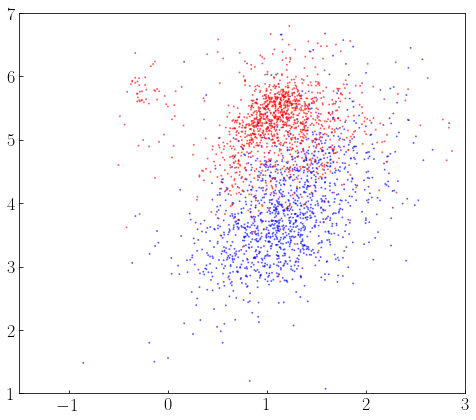

In [42]:
fig, axs = plt.subplots(1, 1, figsize = (8, 7))
massive_gals_z15 = massive_gals_selected[massive_gals_selected['Z_COMBINE']<1.5]
massive_gals_sfq = massive_gals_z15[massive_gals_z15['sfq_nuvrk_myrun_free']>-1]
print(len(massive_gals_z15),len(massive_gals_sfq))

plt.scatter(massive_gals_sfq['MAG_ABS_r']-massive_gals_sfq['MAG_ABS_Ks'], massive_gals_sfq['MAG_ABS_NUV']-massive_gals_sfq['MAG_ABS_r'],c=massive_gals_sfq['CLASS'],
            s=1,alpha=0.5,vmin=0,vmax=1,cmap='bwr_r')
plt.xlim([-1.5,3])
plt.ylim([1,7])


In [43]:
peaky_check = []
zoutlier_check = []
for gal in massive_gals_selected:
    if "N/A" in gal['pdz']:
        peaky_check.append(-1) # -1=no-pdz
    else:
        pdz = np.array(gal['pdz'].split(',')).astype(float)
        pdz_trim = pdz[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
        
        # peaky pdz check
        if len(pdz_trim[pdz_trim>0.25*np.max(pdz_trim)])<=2:
            peaky_check.append(1)  # 1=peaky
        else:
            peaky_check.append(0)  # 0=non-peaky
        
        # z outlier check
        if abs(gal['Z_ML']-gal['lp_zPDF'])<0.15*(1+gal['lp_zPDF']):
            zoutlier_check.append(0) # not outlier
        else:
            zoutlier_check.append(1) # outlier
        
peaky_check = np.array(peaky_check).astype(bool)
zoutlier_check = np.array(zoutlier_check).astype(bool)

peaky_outlier = (peaky_check==True) & (zoutlier_check==True)
nonpeaky_outlier = (peaky_check==False) & (zoutlier_check==True)

print('peaky',len(peaky_check[peaky_check==1]),len(peaky_outlier[peaky_outlier==True]))
print('non-peaky',len(peaky_check[peaky_check==0]),len(nonpeaky_outlier[nonpeaky_outlier==True]))
print('peaky fraction', round(len(peaky_check[peaky_check==1])/len(peaky_check),3))

peaky 1483 268
non-peaky 3476 992
peaky fraction 0.299


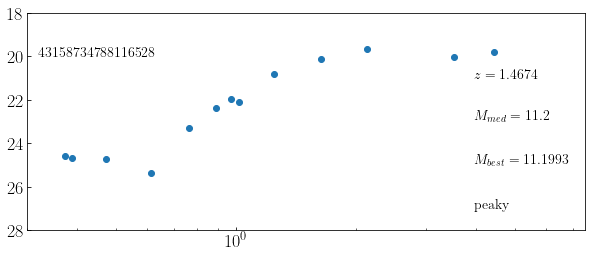

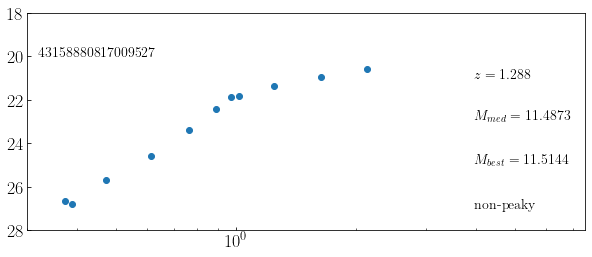

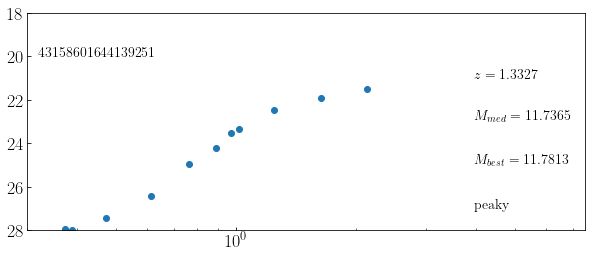

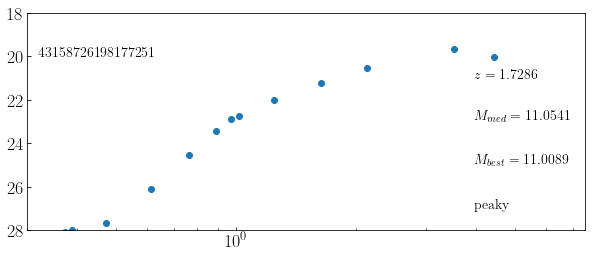

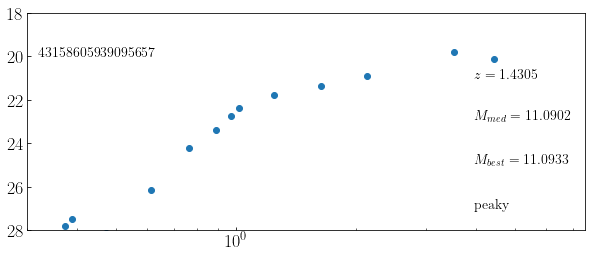

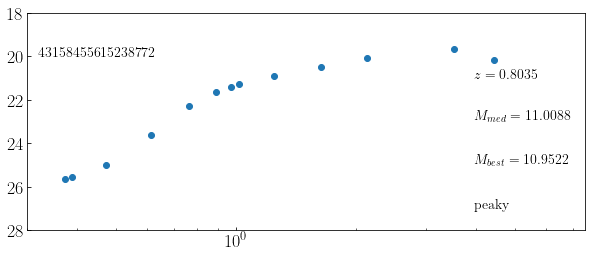

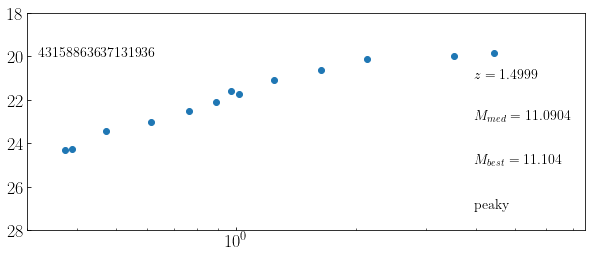

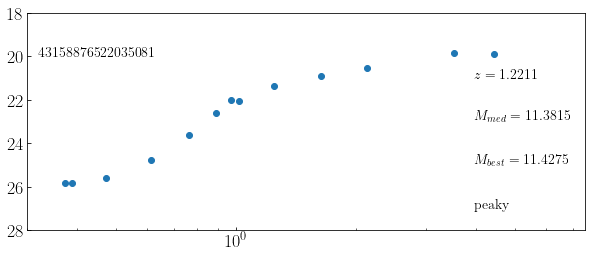

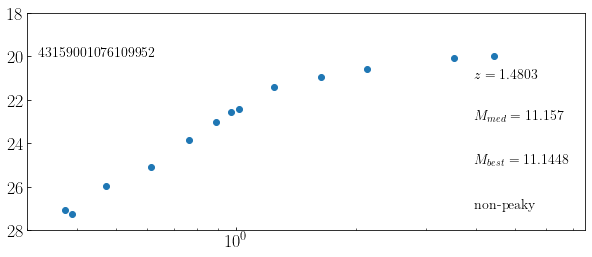

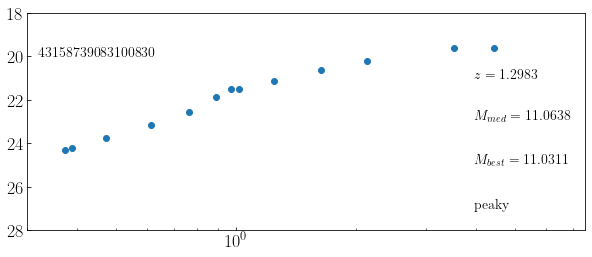

In [45]:
# SEDs

# show SED of massive gals 
wavels = [0.3739,0.3889,0.4718,0.6135,0.7615,0.8898,0.9746,1.0186,1.2468,1.6316,2.1333,3.5133,4.4429] # effective wavelengths of filters
cols = ['u','uS','g','r','i','z','y','Yv','J','H','Ks','MAG_AUTO_CH1_CORR','MAG_AUTO_CH2_CORR']

ids = np.random.randint(low=0,high=len(massive_gals_selected)-1,size=10)
for gal in massive_gals_selected[ids]:
    fig, axs = plt.subplots(1, 1, figsize = (10, 4))
    mags = np.array(gal[cols]).tolist()
    
    # pdz check
    if "N/A" in gal['pdz']:
        peaky_check='no pdz'
    else:
        pdz = np.array(gal['pdz'].split(',')).astype(float)
        pdz_trim = pdz[np.nonzero(pdz)[0][0]:np.nonzero(pdz)[0][-1]+1]
        if len(pdz_trim[pdz_trim>0.25*np.max(pdz_trim)])<=3:
            peaky_check='peaky'  # 1=peaky
        else:
            peaky_check='non-peaky'  # 0=non-peaky

    plt.scatter(wavels,mags)
    plt.ylim([28,18])
    plt.xlim(0.3,7.5)
    plt.xscale('log')
    
    plt.annotate(str(gal['ID_1']),xy=([0.02,0.8]),xycoords='axes fraction',fontsize=14,color='k')
    plt.annotate('$z='+str(gal['Z_ML'])+'$',xy=([0.8,0.7]),xycoords='axes fraction',fontsize=14,color='k')
    plt.annotate('$M_{med}='+str(gal['MASS_MED_massrun'])+'$',xy=([0.8,0.5]),xycoords='axes fraction',fontsize=14,color='k')
    plt.annotate('$M_{best}='+str(gal['MASS_BEST'])+'$',xy=([0.8,0.3]),xycoords='axes fraction',fontsize=14,color='k')
    plt.annotate(peaky_check,xy=([0.8,0.1]),xycoords='axes fraction',fontsize=14,color='k')


#### Jun.20 
temprary: match old lpehare run catalogs to pcats

In [ ]:
# match with CH1 and CH2 catalog

for cat_name in ['COSMOS','DEEP','ELAIS']:
    print(cat_name)
    my_cat_name = '/Volumes/LejaySSD/phosphorus_catalogs/p_cats_v211221/'+cat_name+'_deep_pcat_211221_mags_gals.fits'
    irac_cat_name = '/Volumes/LejaySSD/SHIRAZ_catalogs/trimmed_cats/'+cat_name+'_deep_CH1_trim.fits'
    combined_cat_name = my_cat_name.replace('.fits','_CH1_CH2.fits')
    
    cmd = 'java -jar stilts.jar tmatch2 matcher=sky params="1.0" join="all1"\
       in1='+ my_cat_name + ' values1="RA DEC" \
       in2='+ irac_cat_name + ' values2="ALPHA_J2000 DELTA_J2000" \
       out='+ combined_cat_name
    os.system(cmd)
    
    # remove unnecessary columns
    cat_matched = Table.read(combined_cat_name)
    cat_matched.remove_columns(['ALPHA_J2000','DELTA_J2000','FLUX_AUTO_CH1','FLUXERR_AUTO_CH1'])
    cat_matched.write(my_cat_name.replace('.fits','_CH1_CH2.fits'), overwrite=True)   
    
    
    irac_cat_name = '/Volumes/LejaySSD/SHIRAZ_catalogs/trimmed_cats/'+cat_name+'_deep_CH2_trim.fits'
    cmd = 'java -jar stilts.jar tmatch2 matcher=sky params="1.0" join="all1"\
       in1='+ my_cat_name.replace('.fits','_CH1_CH2.fits') + ' values1="RA DEC" \
       in2='+ irac_cat_name + ' values2="ALPHA_J2000 DELTA_J2000" \
       out='+ combined_cat_name
    os.system(cmd)
    
    # remove unnecessary columns
    cat_matched = Table.read(combined_cat_name)
    cat_matched.remove_columns(['ALPHA_J2000','DELTA_J2000','FLUX_AUTO_CH2','FLUXERR_AUTO_CH2'])
    cat_matched.write(my_cat_name.replace('.fits','_CH1_CH2.fits'), overwrite=True)  
    print(cat_matched.keys())
    
    if cat_name == 'COSMOS':
        # match with COSMOS2020
        C20_cat_name = '/Volumes/LejaySSD/COSMOS2020/COSMOS2020_FARMER_R1_v2.2_trim.fits'
        col_list = "'ALPHA_J2000 DELTA_J2000 HSC_i_MAG HSC_i_MAGERR IRAC_CH1_MAG IRAC_CH1_MAGERR IRAC_CH2_MAG IRAC_CH2_MAGERR lp_zPDF lp_mass_med ez_z500 ez_mass_p500 lp_type FLAG_COMBINED'"
        cmd = 'java -jar stilts.jar tmatch2 matcher=sky params="1.0" join="all1"\
           in1='+ combined_cat_name + ' values1="RA DEC" \
           in2='+ C20_cat_name + ' values2="ALPHA_J2000 DELTA_J2000" \
           out='+ combined_cat_name+' icmd2="keepcols '+col_list+'" '
        print(cmd)
        os.system(cmd)

#### the flux-based catalog

In [ ]:
# load catalog

cat = Table.read()



In [ ]:
# calibration with C20





In [ ]:
# redshift comparison and mass comparison


